<a href="https://colab.research.google.com/github/sergioGarcia91/BucaramangaSeismicNest_ML/blob/main/ML_SismosNido_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

New models will be trained considering only events since 2009 and the magnitude information will be increased from $Ml\geq 1.5$, the same network structures will be maintained.

Predictions will now be for events with $Ml\geq 4.0$.

# Start

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import xyzservices.providers as xyz #para escoger el basemap

from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Para evaluar el modelo
from sklearn.neural_network import MLPClassifier # Para la Red Neuronal
from joblib import dump, load # guardar el modelo
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression # Para generar el Modelo de Reg. Lineal

# Load Data

In [ ]:
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV4/'
# Se carga el catalogo de los eventos de prof mayores a 100 km
df_Filtrado_100km = pd.read_csv(pathDatos+'df_100km.csv')
df_Filtrado_100km['Date-Time'] = pd.to_datetime(df_Filtrado_100km['Date-Time'], yearfirst=True)
df_Filtrado_100km.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148125 entries, 0 to 148124
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   148125 non-null  object        
 1   HORA_UTC                148125 non-null  object        
 2   LATITUD (grados)        148125 non-null  float64       
 3   LONGITUD (grados)       148125 non-null  float64       
 4   PROFUNDIDAD (Km)        148125 non-null  float64       
 5   MAGNITUD Ml             148125 non-null  float64       
 6   ERROR LATITUD (Km)      148125 non-null  float64       
 7   ERROR LONGITUD (Km)     148125 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  148125 non-null  float64       
 9   Date-Time               148125 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 11.3+ MB


In [ ]:
df_Filtrado_100km_ml15 = df_Filtrado_100km[df_Filtrado_100km['MAGNITUD Ml'] >= 1.5].copy()
df_Filtrado_100km_ml15.describe()

LATITUD (grados)  LONGITUD (grados)  PROFUNDIDAD (Km)    MAGNITUD Ml  \
count     131657.000000      131657.000000     131657.000000  131657.000000   
mean           6.799721         -73.126240        144.074667       2.153588   
min            6.500000         -73.400000        100.000000       1.500000   
25%            6.775000         -73.171000        140.200000       1.700000   
50%            6.801000         -73.141000        144.700000       2.000000   
75%            6.825000         -73.090000        148.600000       2.400000   
max            7.100000         -72.800000        436.500000       6.300000   
std            0.050429           0.079662          7.671223       0.581689   

       ERROR LATITUD (Km)  ERROR LONGITUD (Km)  ERROR PROFUNDIDAD (Km)  \
count       131657.000000        131657.000000           131657.000000   
mean             4.604049             7.015817                7.139087   
min              0.000000             0.000000                0.000000   
25%              2.600000             3.041000                4.200000   
50%              4.000000             5.200000                6.500000   
75%              5.798000             9.000000                8.920000   
max             99.900000            99.900000               99.900000   
std              3.280218             6.301304                5.056728   

                           Date-Time  
count                         131657  
mean   2014-01-15 19:01:14.954351360  
min              1994-01-01 00:06:37  
25%              2009-01-31 03:01:08  
50%              2015-10-28 06:42:17  
75%              2020-08-23 14:14:12  
max              2024-02-29 23:17:12  
std                              NaN

# Df for days

In [ ]:
dict_Dias = {'Dia':[],
             '1.5-2.0':[],
             '2.0-2.5':[],
             '2.5-3.0':[],
             '3.0-3.5':[],
             '3.5-4.0':[],
             '4.0-4.5':[],
             '4.5-5.0':[],
             '5.0-5.5':[],
             '5.5-':[],}

# Apparently not every day there is a record of events with depths
# greater than 100 km and magnitudes greater than 1.5
inicio = np.datetime64('1994-01-01')
fin = np.datetime64('2024-03-01')
array_fechas = np.arange(inicio, fin, dtype='datetime64[D]')

for date in array_fechas:
  df_filtrado = df_Filtrado_100km_ml15[df_Filtrado_100km_ml15['FECHA'] == str(date)]
  dict_Dias['Dia'].append(str(date))

  for ml in np.arange(1.5, 6.0, 0.5):
    if ml == 5.5:
      nE = df_filtrado['MAGNITUD Ml'] >= 5.5

      dict_Dias['5.5-'].append(sum(nE))

    else:
      nE = (df_filtrado['MAGNITUD Ml'] >= ml) & (df_filtrado['MAGNITUD Ml'] < (ml+0.5) )
      strDict = f'{ml}-{ml+0.5}'

      dict_Dias[strDict].append(sum(nE))

df_Dias = pd.DataFrame.from_dict(dict_Dias)
df_Dias['Total dia'] = df_Dias.iloc[:,1:].sum(axis=1)
df_Dias

Dia  1.5-2.0  2.0-2.5  2.5-3.0  3.0-3.5  3.5-4.0  4.0-4.5  \
0      1994-01-01        0        0        0        0        1        1   
1      1994-01-02        0        0        1        4        0        0   
2      1994-01-03        0        0        0        1        0        1   
3      1994-01-04        0        0        0        3        1        0   
4      1994-01-05        0        0        2        2        1        0   
...           ...      ...      ...      ...      ...      ...      ...   
11012  2024-02-25       44        5        1        0        0        0   
11013  2024-02-26       31        7        6        1        0        0   
11014  2024-02-27       37        5        2        0        0        0   
11015  2024-02-28       35        7        4        0        0        0   
11016  2024-02-29       24        3        5        0        0        0   

       4.5-5.0  5.0-5.5  5.5-  Total dia  
0            0        0     0          2  
1            0        1     0          6  
2            0        0     0          2  
3            0        0     0          4  
4            1        0     0          6  
...        ...      ...   ...        ...  
11012        0        0     0         50  
11013        0        0     0         45  
11014        0        0     0         44  
11015        0        0     0         46  
11016        0        0     0         32  

[11017 rows x 11 columns]

In [ ]:
df_Dias.to_csv(pathDatos+'df_Dias_v3_ml15_2009.csv', index=False)

## Load Df_v3

In [ ]:
df_Dias = pd.read_csv(pathDatos+'df_Dias_v3_ml15_2009.csv')
df_Dias['Fecha'] = pd.to_datetime(df_Dias['Dia'], yearfirst=True)
filtro2009 = (df_Dias['Fecha'].dt.year >= 2009).to_numpy()
df_Dias = df_Dias[filtro2009]
df_Dias.reset_index(inplace=True, drop=True)
df_Dias

Dia  1.5-2.0  2.0-2.5  2.5-3.0  3.0-3.5  3.5-4.0  4.0-4.5  \
0     2009-01-01        5        0        1        0        0        0   
1     2009-01-02        4        0        2        1        0        0   
2     2009-01-03        5        1        0        1        0        0   
3     2009-01-04        7        1        2        0        0        0   
4     2009-01-05        5        2        0        0        0        0   
...          ...      ...      ...      ...      ...      ...      ...   
5533  2024-02-25       44        5        1        0        0        0   
5534  2024-02-26       31        7        6        1        0        0   
5535  2024-02-27       37        5        2        0        0        0   
5536  2024-02-28       35        7        4        0        0        0   
5537  2024-02-29       24        3        5        0        0        0   

      4.5-5.0  5.0-5.5  5.5-  Total dia      Fecha  
0           0        0     0          6 2009-01-01  
1           0        0     0          7 2009-01-02  
2           0        0     0          7 2009-01-03  
3           0        0     0         10 2009-01-04  
4           0        0     0          7 2009-01-05  
...       ...      ...   ...        ...        ...  
5533        0        0     0         50 2024-02-25  
5534        0        0     0         45 2024-02-26  
5535        0        0     0         44 2024-02-27  
5536        0        0     0         46 2024-02-28  
5537        0        0     0         32 2024-02-29  

[5538 rows x 12 columns]

In [ ]:
# Let's add the 4 columns of interest
df_Dias['Y'] = df_Dias[['4.0-4.5', '4.5-5.0', '5.0-5.5', '5.5-']].sum(axis=1)
np.round(df_Dias.describe())

1.5-2.0  2.0-2.5  2.5-3.0  3.0-3.5  3.5-4.0  4.0-4.5  4.5-5.0  5.0-5.5  \
count   5538.0   5538.0   5538.0   5538.0   5538.0   5538.0   5538.0   5538.0   
mean      11.0      5.0      1.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        6.0      3.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        9.0      4.0      1.0      0.0      0.0      0.0      0.0      0.0   
75%       15.0      6.0      2.0      1.0      0.0      0.0      0.0      0.0   
max       49.0     24.0      9.0      5.0      3.0      2.0      2.0      1.0   
std        7.0      3.0      1.0      1.0      0.0      0.0      0.0      0.0   

         5.5-  Total dia                          Fecha       Y  
count  5538.0     5538.0                           5538  5538.0  
mean      0.0       18.0  2016-07-31 12:00:00.000000256     0.0  
min       0.0        0.0            2009-01-01 00:00:00     0.0  
25%       0.0       12.0            2012-10-16 06:00:00     0.0  
50%       0.0       16.0            2016-07-31 12:00:00     0.0  
75%       0.0       23.0            2020-05-15 18:00:00     0.0  
max       1.0       64.0            2024-02-29 00:00:00     2.0  
std       0.0        8.0                            NaN     0.0

# Split 30 days

In [ ]:
y = []
X = []

dias_Considerar = 30

for dias in range(dias_Considerar-1, len(df_Dias)-6):
  di_ = dias_Considerar-1
  datos = df_Dias[['1.5-2.0', '2.0-2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0', '5.0-5.5', '5.5-']].iloc[dias-di_:dias+1].to_numpy()
  #print(datos.shape)
  datos = np.reshape(datos, (1,-1))
  #print(datos.shape)
  X.append(datos.tolist()[0])

  target = df_Dias['Y'].iloc[dias+1:dias+7].sum()

  if target > 0 :
    y.append(1)
  else:
    y.append(0)
y = np.reshape(np.array(y), (-1,1))
X = np.array(X)

In [ ]:
y.shape

(5503, 1)

In [ ]:
X.shape

(5503, 270)

In [ ]:
df_yX = pd.DataFrame(np.concatenate((X,y), axis=1))
df_yX

0    1    2    3    4    5    6    7    8    9    ...  261  262  263  \
0       5    0    1    0    0    0    0    0    0    4  ...    4    2    3   
1       4    0    2    1    0    0    0    0    0    5  ...    9    5    0   
2       5    1    0    1    0    0    0    0    0    7  ...    6    7    0   
3       7    1    2    0    0    0    0    0    0    5  ...    6    4    1   
4       5    2    0    0    0    0    0    0    0    6  ...    4    4    2   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5498   20    7    3    1    1    0    0    1    0   24  ...   25    9    0   
5499   24   16    0    1    0    0    1    0    0   17  ...   18   11    2   
5500   17   24    4    2    0    0    0    0    0   12  ...   36   11    1   
5501   12   16    2    0    0    0    0    0    0   21  ...   39    4    2   
5502   21   20    4    0    0    0    0    0    0   21  ...   32    1    2   

      264  265  266  267  268  269  270  
0       1    0    0    0    0    0    1  
1       1    0    1    0    0    0    0  
2       0    1    0    0    0    0    0  
3       1    0    0    0    0    0    0  
4       0    0    0    0    0    0    0  
...   ...  ...  ...  ...  ...  ...  ...  
5498    2    0    0    0    0    0    1  
5499    0    0    1    1    0    0    1  
5500    1    0    0    0    0    0    1  
5501    0    1    0    1    0    0    1  
5502    1    1    0    0    0    0    1  

[5503 rows x 271 columns]

In [ ]:
# Split de los datos
# Se va tomar los eventos < 2022 para entrenar
# y los >= 2022 para predecir
filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

y2021 = df_yX.iloc[:,-1][filtro2022].to_numpy()
X2021 = df_yX.iloc[:,:-1][filtro2022].to_numpy()

y2022 = df_yX.iloc[:,-1][filtro2023].to_numpy()
X2022 = df_yX.iloc[:,:-1][filtro2023].to_numpy()

In [ ]:
# se guardan los datos
prefijo = pathDatos + '2009ml15_30dias'
print(prefijo)
np.savetxt(f'{prefijo}_y2021.txt', y2021)
np.savetxt(f'{prefijo}_X2021.txt', X2021)
np.savetxt(f'{prefijo}_y2022.txt', y2022)
np.savetxt(f'{prefijo}_X2022.txt', X2022)

/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/2009ml15_30dias


#Split 6 months

In [ ]:
y = []
X = []

dias_Considerar = 180

for dias in range(dias_Considerar-1, len(df_Dias)-6):
  di_ = dias_Considerar-1
  datos = df_Dias[['1.5-2.0', '2.0-2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0', '5.0-5.5', '5.5-']].iloc[dias-di_:dias+1].to_numpy()
  #print(datos.shape)
  datos = np.reshape(datos, (1,-1))
  #print(datos.shape)
  X.append(datos.tolist()[0])

  target = df_Dias['Y'].iloc[dias+1:dias+7].sum()

  if target > 0 :
    y.append(1)
  else:
    y.append(0)
y = np.reshape(np.array(y), (-1,1))
X = np.array(X)

In [ ]:
y.shape

(5353, 1)

In [ ]:
X.shape

(5353, 1620)

In [ ]:
df_yX = pd.DataFrame(np.concatenate((X,y), axis=1))
df_yX

0     1     2     3     4     5     6     7     8     9     ...  1611  \
0        5     0     1     0     0     0     0     0     0     4  ...     6   
1        4     0     2     1     0     0     0     0     0     5  ...     8   
2        5     1     0     1     0     0     0     0     0     7  ...     2   
3        7     1     2     0     0     0     0     0     0     5  ...     7   
4        5     2     0     0     0     0     0     0     0     6  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
5348    21     7     1     3     0     0     0     0     0    25  ...    25   
5349    25    11     1     1     0     0     0     0     0    20  ...    18   
5350    20     1     0     0     1     0     0     0     0    17  ...    36   
5351    17     2     1     2     0     0     0     0     0    19  ...    39   
5352    19     8     2     2     1     0     0     0     0    12  ...    32   

      1612  1613  1614  1615  1616  1617  1618  1619  1620  
0        2     0     0     0     0     0     0     0     1  
1        5     0     1     0     0     0     0     0     1  
2        2     1     0     0     0     0     0     0     1  
3        2     0     0     0     0     0     0     0     1  
4        3     3     0     0     0     0     0     0     1  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
5348     9     0     2     0     0     0     0     0     1  
5349    11     2     0     0     1     1     0     0     1  
5350    11     1     1     0     0     0     0     0     1  
5351     4     2     0     1     0     1     0     0     1  
5352     1     2     1     1     0     0     0     0     1  

[5353 rows x 1621 columns]

In [ ]:
# Split de los datos
# Se va tomar los eventos < 2022 para entrenar
# y los >= 2022 para predecir
filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

y2021 = df_yX.iloc[:,-1][filtro2022].to_numpy()
X2021 = df_yX.iloc[:,:-1][filtro2022].to_numpy()

y2022 = df_yX.iloc[:,-1][filtro2023].to_numpy()
X2022 = df_yX.iloc[:,:-1][filtro2023].to_numpy()

In [ ]:
# se guardan los datos
prefijo = pathDatos + '2009ml15_6meses'
print(prefijo)
np.savetxt(f'{prefijo}_y2021.txt', y2021)
np.savetxt(f'{prefijo}_X2021.txt', X2021)
np.savetxt(f'{prefijo}_y2022.txt', y2022)
np.savetxt(f'{prefijo}_X2022.txt', X2022)

/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/2009ml15_6meses


#Split 12 months

In [ ]:
y = []
X = []

dias_Considerar = 365 # para 12 meses

for dias in range(dias_Considerar-1, len(df_Dias)-6):
  di_ = dias_Considerar-1
  datos = df_Dias[['1.5-2.0', '2.0-2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0', '5.0-5.5', '5.5-']].iloc[dias-di_:dias+1].to_numpy()
  #print(datos.shape)
  datos = np.reshape(datos, (1,-1))
  #print(datos.shape)
  X.append(datos.tolist()[0])


  target = df_Dias['Y'].iloc[dias+1:dias+7].sum()

  if target > 0 :
    y.append(1)
  else:
    y.append(0)
y = np.reshape(np.array(y), (-1,1))
X = np.array(X)

In [ ]:
y.shape

(5168, 1)

In [ ]:
X.shape

(5168, 3285)

In [ ]:
df_yX = pd.DataFrame(np.concatenate((X,y), axis=1))
df_yX

0     1     2     3     4     5     6     7     8     9     ...  3276  \
0        5     0     1     0     0     0     0     0     0     4  ...     4   
1        4     0     2     1     0     0     0     0     0     5  ...     5   
2        5     1     0     1     0     0     0     0     0     7  ...     8   
3        7     1     2     0     0     0     0     0     0     5  ...     5   
4        5     2     0     0     0     0     0     0     0     6  ...     3   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
5163    17     2     1     0     0     0     0     0     0    18  ...    25   
5164    18    12     1     0     1     0     0     0     0    15  ...    18   
5165    15     8     5     0     0     0     0     0     0    13  ...    36   
5166    13     9     0     0     0     0     0     0     0     8  ...    39   
5167     8     3     4     3     1     0     0     0     0    20  ...    32   

      3277  3278  3279  3280  3281  3282  3283  3284  3285  
0        3     2     1     0     0     0     0     0     1  
1        1     1     1     0     0     0     0     0     1  
2        3     1     0     0     0     0     0     0     1  
3        8     0     0     1     0     0     0     0     1  
4        2     3     0     0     1     0     0     0     0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
5163     9     0     2     0     0     0     0     0     1  
5164    11     2     0     0     1     1     0     0     1  
5165    11     1     1     0     0     0     0     0     1  
5166     4     2     0     1     0     1     0     0     1  
5167     1     2     1     1     0     0     0     0     1  

[5168 rows x 3286 columns]

In [ ]:
# Split de los datos
# Se va tomar los eventos < 2022 para entrenar
# y los >= 2022 para predecir
filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

y2021 = df_yX.iloc[:,-1][filtro2022].to_numpy()
X2021 = df_yX.iloc[:,:-1][filtro2022].to_numpy()

y2022 = df_yX.iloc[:,-1][filtro2023].to_numpy()
X2022 = df_yX.iloc[:,:-1][filtro2023].to_numpy()

In [ ]:
# se guardan los datos
prefijo = pathDatos + '2009ml15_12meses'
print(prefijo)
np.savetxt(f'{prefijo}_y2021.txt', y2021)
np.savetxt(f'{prefijo}_X2021.txt', X2021)
np.savetxt(f'{prefijo}_y2022.txt', y2022)
np.savetxt(f'{prefijo}_X2022.txt', X2022)

/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/2009ml15_12meses


# MLPClass Training

In [ ]:
# Se cargan los archivos
#prefijo = '2009ml15_30dias'
#prefijo = '2009ml15_6meses'
prefijo = '2009ml15_12meses'

X2022 = np.loadtxt(pathDatos + prefijo + '_X2022.txt')
y2022 = np.loadtxt(pathDatos + prefijo + '_y2022.txt')
X2021 = np.loadtxt(pathDatos + prefijo + '_X2021.txt')
y2021 = np.loadtxt(pathDatos + prefijo + '_y2021.txt')

In [ ]:
X2021.shape

(4384, 3285)

In [ ]:
letras = prefijo
pathSave = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v5/'

# Propuesta de 4 estructuras considerando los 8 modelos anteriores
estuctura = [[2000, 5],
             [1500, 5],
             [420, 5],
             [210, 5]]

scoreInteres = 0.5
intentos = 5
print(prefijo, '\n')
for hl in estuctura:
  print('---- ',hl)

  c = 0

  while c <= intentos:
    print('\n ', c)

    modelo_MLPClass = MLPClassifier(hidden_layer_sizes=tuple(hl),
                                  activation='relu', #identity, logistic, tanh, relu
                                  early_stopping=False, solver='adam', max_iter=30)#, random_state= 0)
    # Se entrena
    tinicio = time.perf_counter() # Segundos

    modelo_MLPClass.fit(X2021, y2021)

    tfinal = time.perf_counter() # Segundos
    tiempo = tfinal - tinicio

    print('Segundos empleados: ',tiempo)

    scoreMLPClass = modelo_MLPClass.score(X2021, y2021)
    print('Score: ', scoreMLPClass)


    if scoreMLPClass >= scoreInteres:
      # guardar modelo
      Name = letras + f'_hl_{hl[0]}_{hl[1]}_int' + str(c) + '_scr' + str(round(scoreMLPClass, 3)) + '.joblib'
      dump(modelo_MLPClass, pathSave+Name)
      print(Name)
      break

    if c == intentos:
      print('Nada ...')
    c += 1

2009ml15_12meses 

----  [2000, 5]

  0


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Segundos empleados:  318.4410969310011
Score:  0.5741332116788321
2009ml15_12meses_hl_2000_5_int0_scr0.574.joblib
----  [1500, 5]

  0


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Segundos empleados:  233.1670445840009
Score:  0.5741332116788321
2009ml15_12meses_hl_1500_5_int0_scr0.574.joblib
----  [420, 5]

  0
Segundos empleados:  54.77986163700007
Score:  0.5741332116788321
2009ml15_12meses_hl_420_5_int0_scr0.574.joblib
----  [210, 5]

  0


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Segundos empleados:  33.910178166999685
Score:  0.7682481751824818
2009ml15_12meses_hl_210_5_int0_scr0.768.joblib


For 6/12 months it seems that they are unable to exceed the score of 0.57, those higher than 0.5 are saved.

# Plot the models

In [ ]:
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV5/'
df = pd.read_csv(pathDatos+'df_100km.csv')
df['Date-Time'] = pd.to_datetime(df['Date-Time'], yearfirst=True)
filtro2009 = (df['Date-Time'].dt.year >= 2009).to_numpy()
df = df[filtro2009]
df_Dias.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115404 entries, 32721 to 148124
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   115404 non-null  object        
 1   HORA_UTC                115404 non-null  object        
 2   LATITUD (grados)        115404 non-null  float64       
 3   LONGITUD (grados)       115404 non-null  float64       
 4   PROFUNDIDAD (Km)        115404 non-null  float64       
 5   MAGNITUD Ml             115404 non-null  float64       
 6   ERROR LATITUD (Km)      115404 non-null  float64       
 7   ERROR LONGITUD (Km)     115404 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  115404 non-null  float64       
 9   Date-Time               115404 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 9.7+ MB


In [ ]:
df.describe()

LATITUD (grados)  LONGITUD (grados)  PROFUNDIDAD (Km)    MAGNITUD Ml  \
count     115404.000000      115404.000000     115404.000000  115404.000000   
mean           6.791251         -73.151096        142.623548       1.874369   
min            6.500000         -73.400000        100.000000       0.100000   
25%            6.767000         -73.179000        139.140000       1.600000   
50%            6.793000         -73.153000        143.650000       1.800000   
75%            6.816000         -73.125000        147.180000       2.100000   
max            7.100000         -72.800000        436.500000       6.300000   
std            0.050677           0.063179          7.393711       0.485847   

       ERROR LATITUD (Km)  ERROR LONGITUD (Km)  ERROR PROFUNDIDAD (Km)  \
count       115404.000000        115404.000000           115404.000000   
mean             3.879041             4.772173                5.706485   
min              0.071000             0.071000                0.000000   
25%              2.263000             2.404000                3.200000   
50%              3.598000             4.300000                5.745000   
75%              5.091000             6.152000                7.600000   
max             45.700000            95.700000               89.900000   
std              2.254905             3.417014                3.020141   

                           Date-Time  
count                         115404  
mean   2017-07-31 07:41:57.754679040  
min              2009-01-01 01:02:58  
25%              2013-09-27 11:01:44  
50%       2018-04-05 11:53:07.500000  
75%       2021-04-03 21:56:20.500000  
max              2024-02-29 23:17:12  
std                              NaN

In [ ]:
df_Dias = pd.read_csv(pathDatos+'df_Dias_v3_ml15_2009.csv')
df_Dias['Fecha'] = pd.to_datetime(df_Dias['Dia'], yearfirst=True)
filtro2009 = (df_Dias['Fecha'].dt.year >= 2009).to_numpy()
df_Dias = df_Dias[filtro2009]
df_Dias.reset_index(inplace=True, drop=True)
df_Dias

Dia  1.5-2.0  2.0-2.5  2.5-3.0  3.0-3.5  3.5-4.0  4.0-4.5  \
0     2009-01-01        5        0        1        0        0        0   
1     2009-01-02        4        0        2        1        0        0   
2     2009-01-03        5        1        0        1        0        0   
3     2009-01-04        7        1        2        0        0        0   
4     2009-01-05        5        2        0        0        0        0   
...          ...      ...      ...      ...      ...      ...      ...   
5533  2024-02-25       44        5        1        0        0        0   
5534  2024-02-26       31        7        6        1        0        0   
5535  2024-02-27       37        5        2        0        0        0   
5536  2024-02-28       35        7        4        0        0        0   
5537  2024-02-29       24        3        5        0        0        0   

      4.5-5.0  5.0-5.5  5.5-  Total dia      Fecha  
0           0        0     0          6 2009-01-01  
1           0        0     0          7 2009-01-02  
2           0        0     0          7 2009-01-03  
3           0        0     0         10 2009-01-04  
4           0        0     0          7 2009-01-05  
...       ...      ...   ...        ...        ...  
5533        0        0     0         50 2024-02-25  
5534        0        0     0         45 2024-02-26  
5535        0        0     0         44 2024-02-27  
5536        0        0     0         46 2024-02-28  
5537        0        0     0         32 2024-02-29  

[5538 rows x 12 columns]

In [ ]:
listaModelos = !ls /content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v5
listaModelos

['2009ml15_12meses_hl_1500_5_int0_scr0.574.joblib  2009ml15_6meses_hl_1500_5_int0_scr0.932.joblib',
 '2009ml15_12meses_hl_2000_5_int0_scr0.574.joblib  2009ml15_6meses_hl_1500_5_int5_scr0.935.joblib',
 '2009ml15_12meses_hl_210_5_int0_scr0.768.joblib\t 2009ml15_6meses_hl_2000_5_int1_scr0.571.joblib',
 '2009ml15_12meses_hl_420_5_int0_scr0.574.joblib\t 2009ml15_6meses_hl_2000_5_int4_scr0.962.joblib',
 '2009ml15_30dias_hl_1500_5_int5_scr0.991.joblib\t 2009ml15_6meses_hl_210_5_int0_scr0.571.joblib',
 '2009ml15_30dias_hl_2000_5_int4_scr0.969.joblib\t 2009ml15_6meses_hl_210_5_int3_scr0.824.joblib',
 '2009ml15_30dias_hl_210_5_int4_scr0.902.joblib\t 2009ml15_6meses_hl_420_5_int0_scr0.571.joblib',
 '2009ml15_30dias_hl_420_5_int4_scr0.944.joblib']

In [ ]:
listaModelos = ['2009ml15_12meses_hl_1500_5_int0_scr0.574.joblib',
                '2009ml15_6meses_hl_1500_5_int0_scr0.932.joblib',
                '2009ml15_12meses_hl_2000_5_int0_scr0.574.joblib',
                '2009ml15_6meses_hl_1500_5_int5_scr0.935.joblib',
                '2009ml15_12meses_hl_210_5_int0_scr0.768.joblib',
                '2009ml15_6meses_hl_2000_5_int1_scr0.571.joblib',
                '2009ml15_12meses_hl_420_5_int0_scr0.574.joblib',
                '2009ml15_6meses_hl_2000_5_int4_scr0.962.joblib',
                '2009ml15_30dias_hl_1500_5_int5_scr0.991.joblib',
                '2009ml15_6meses_hl_210_5_int0_scr0.571.joblib',
                '2009ml15_30dias_hl_2000_5_int4_scr0.969.joblib',
                '2009ml15_6meses_hl_210_5_int3_scr0.824.joblib',
                '2009ml15_30dias_hl_210_5_int4_scr0.902.joblib',
                '2009ml15_6meses_hl_420_5_int0_scr0.571.joblib',
                '2009ml15_30dias_hl_420_5_int4_scr0.944.joblib']

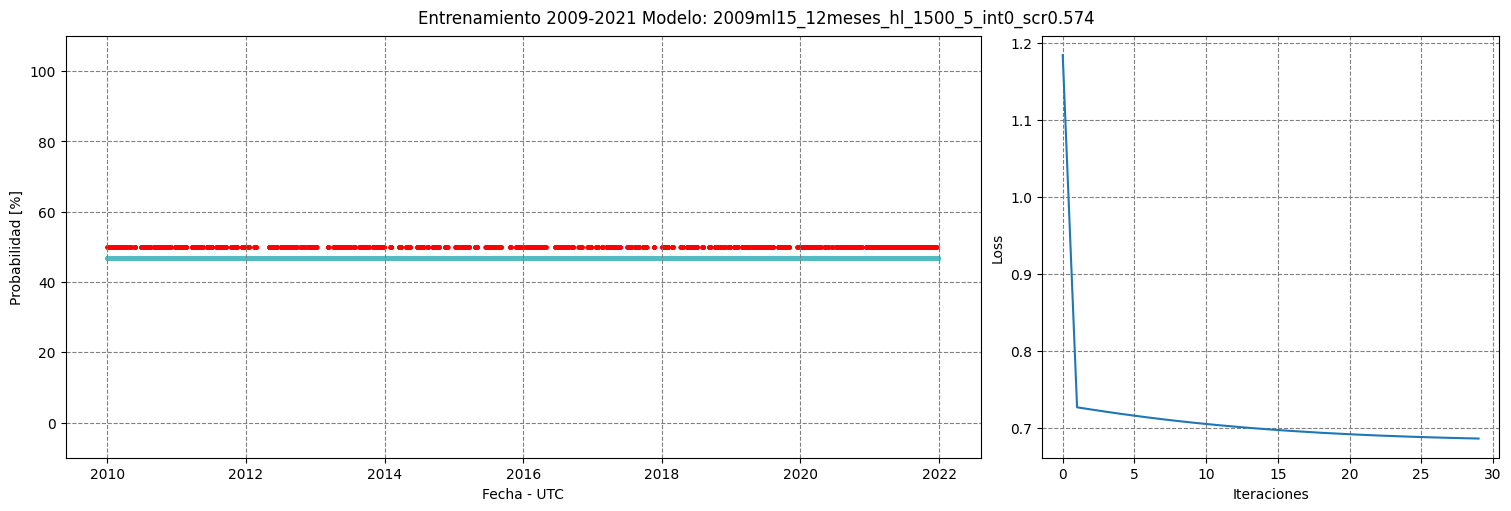

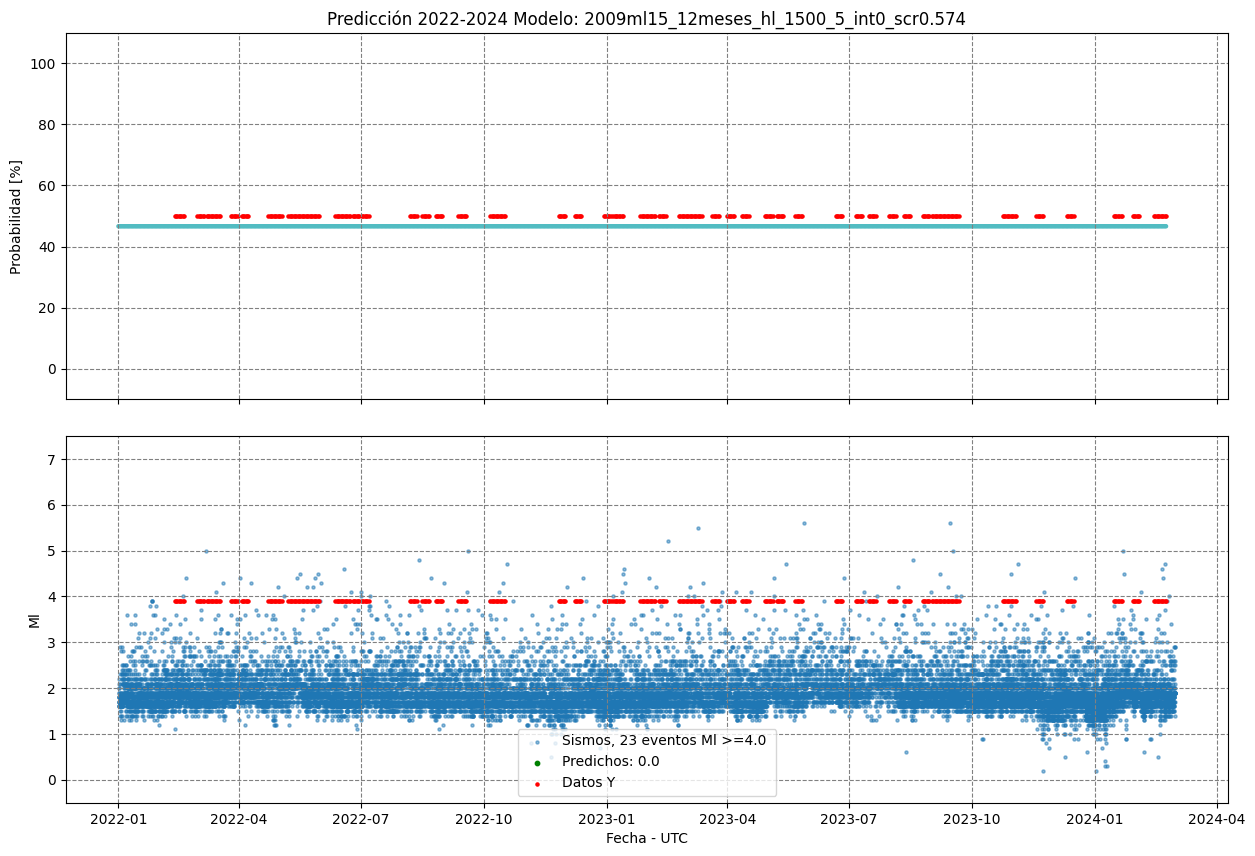

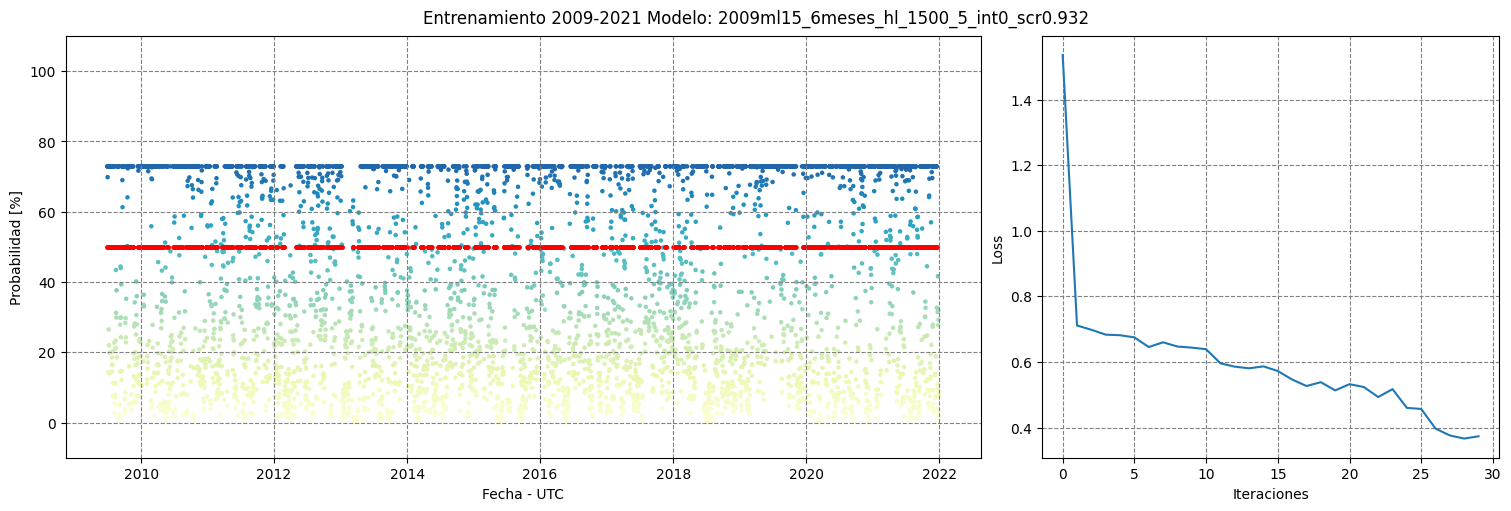

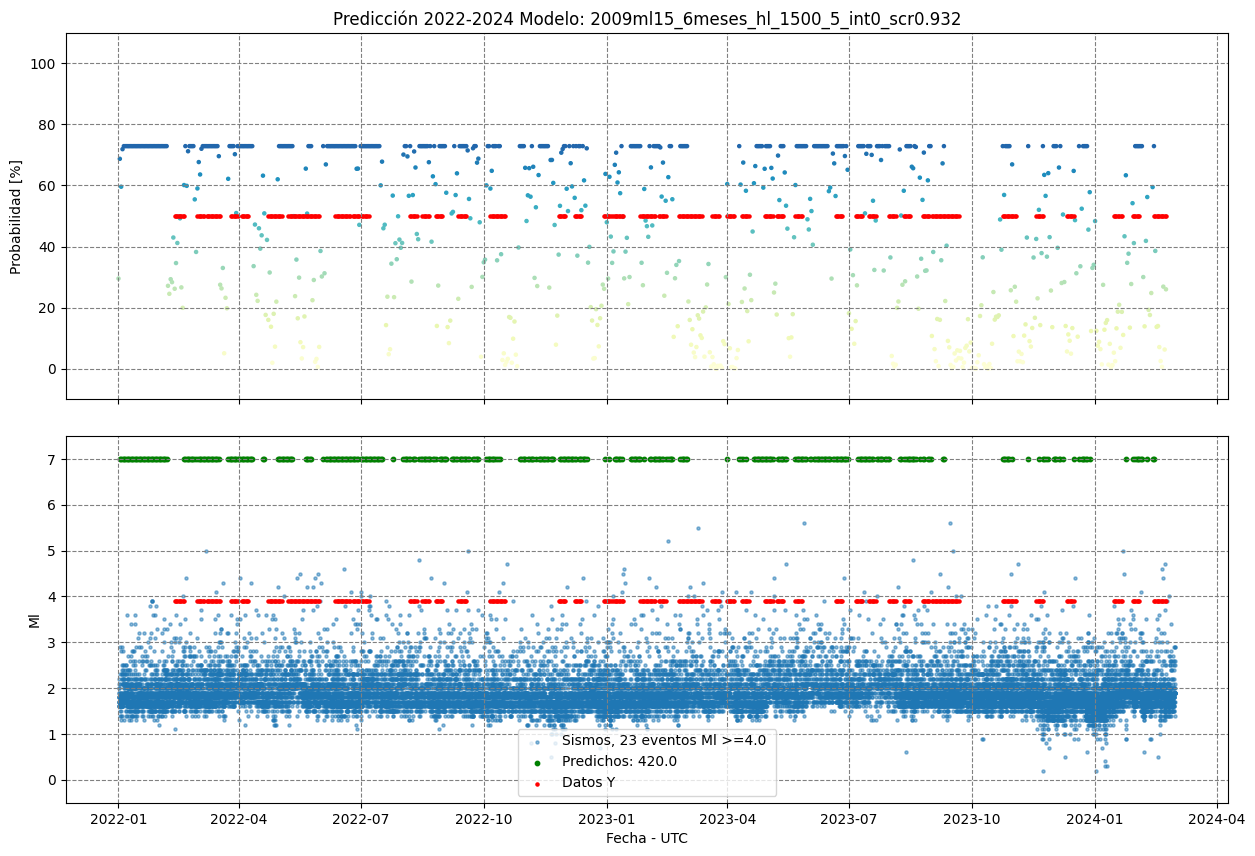

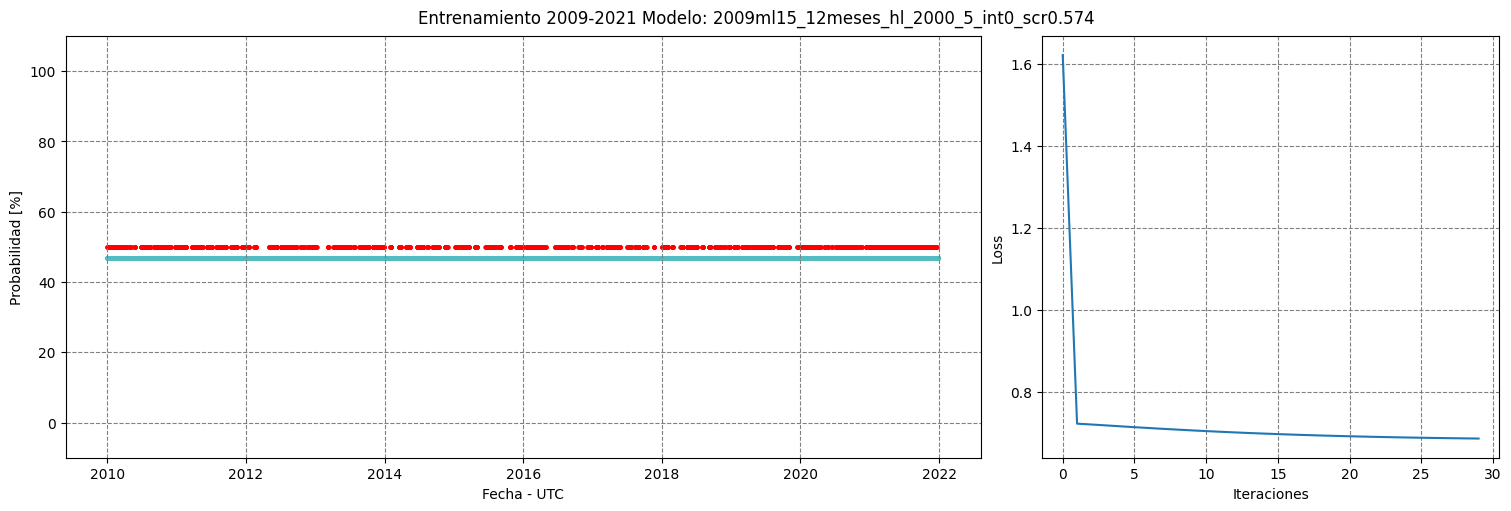

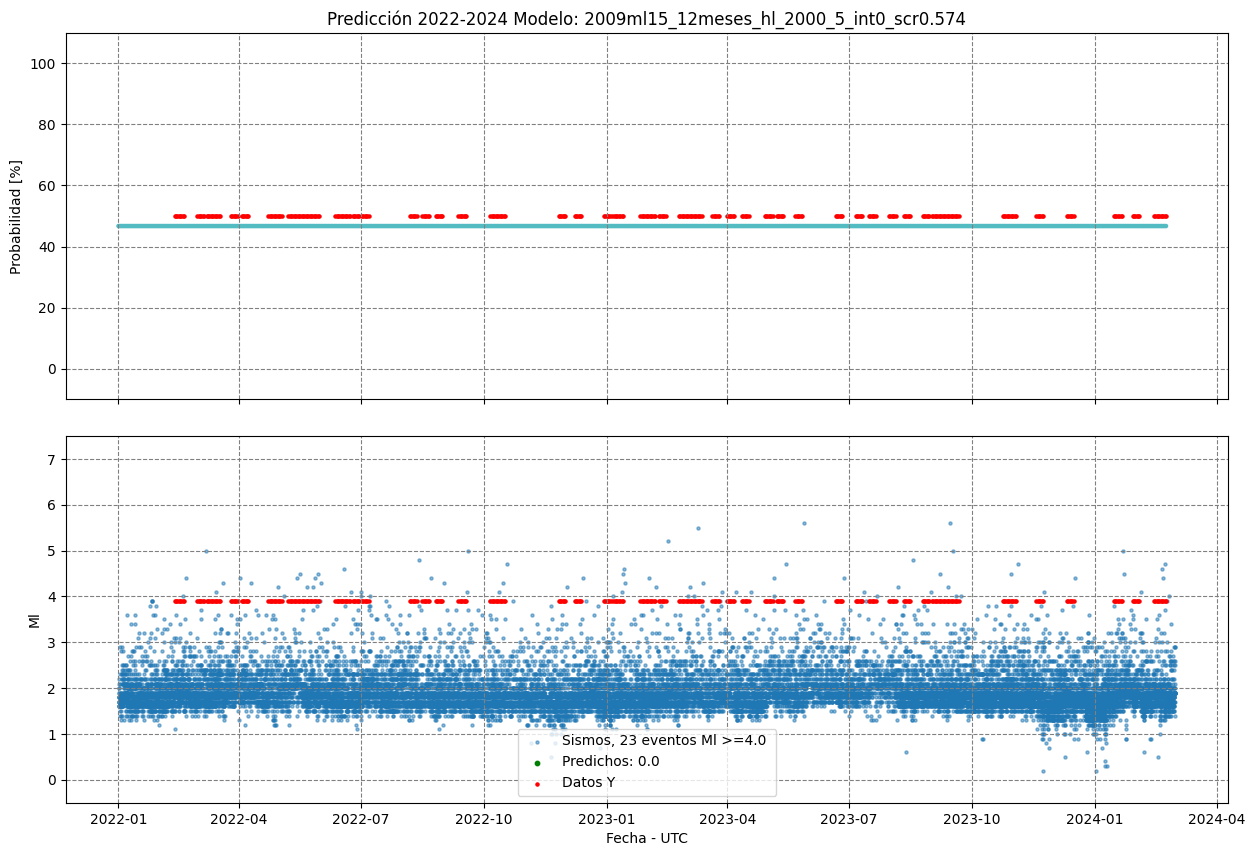

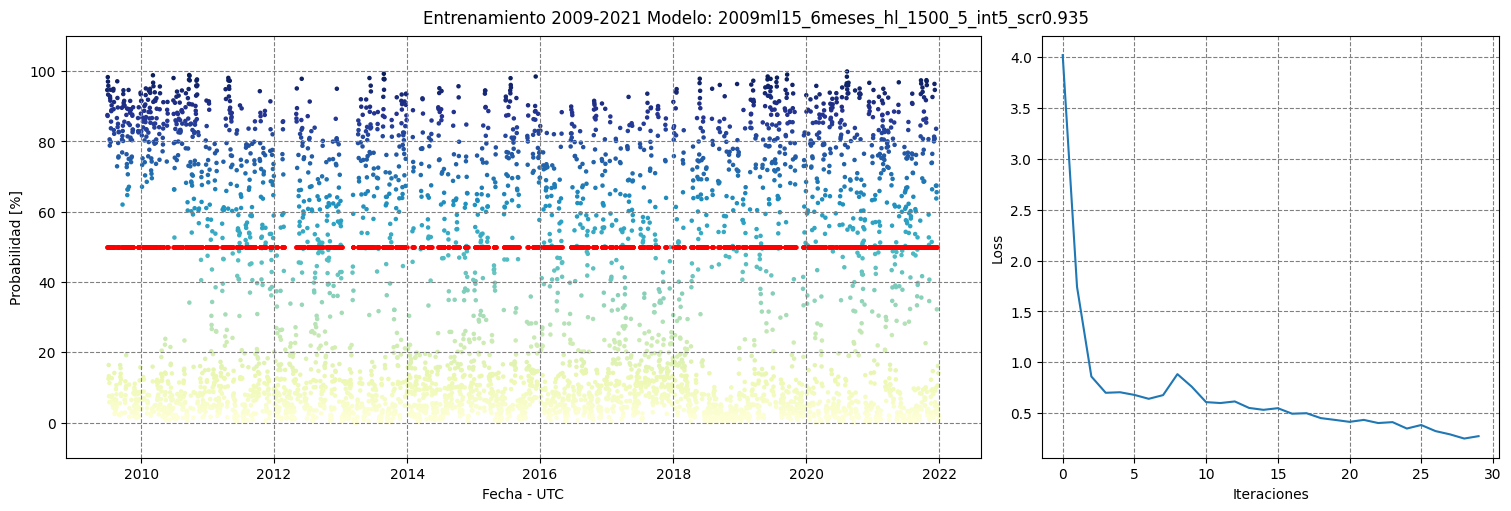

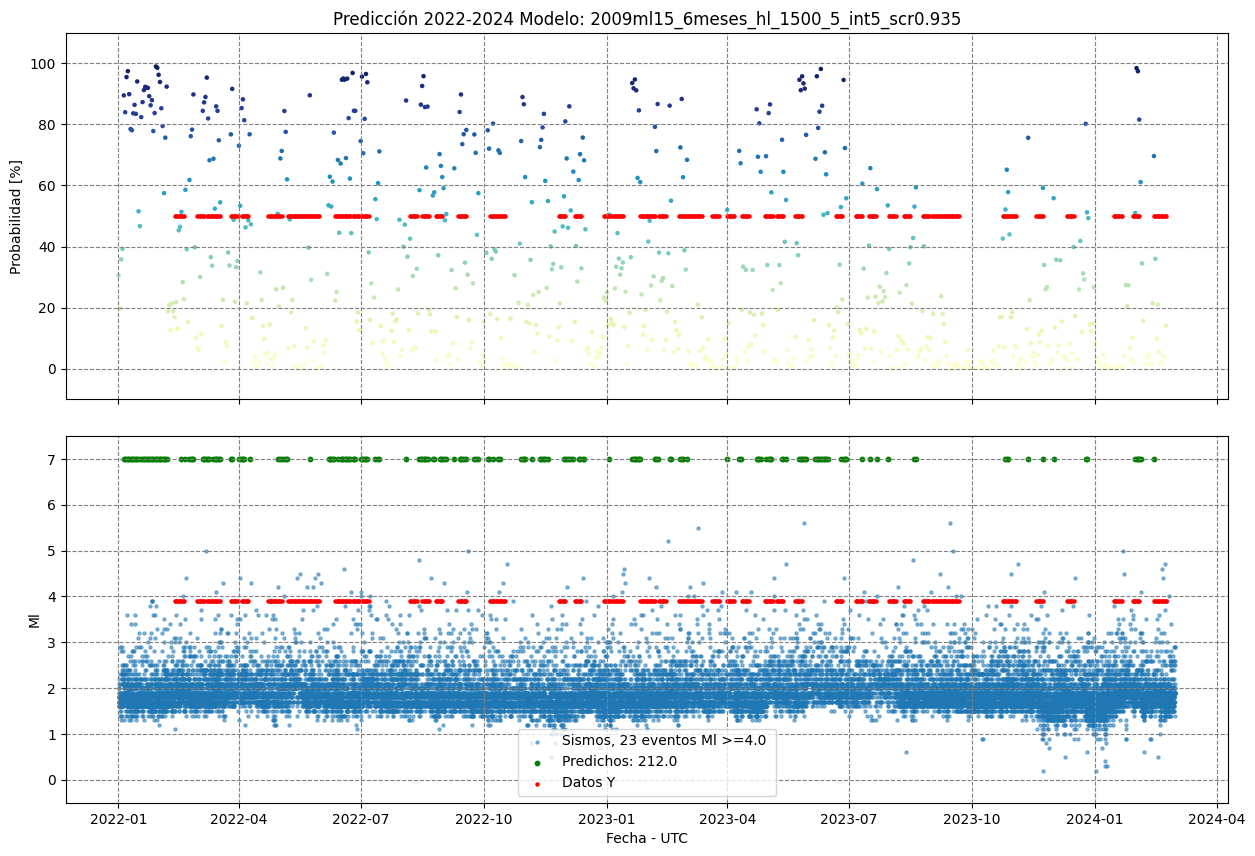

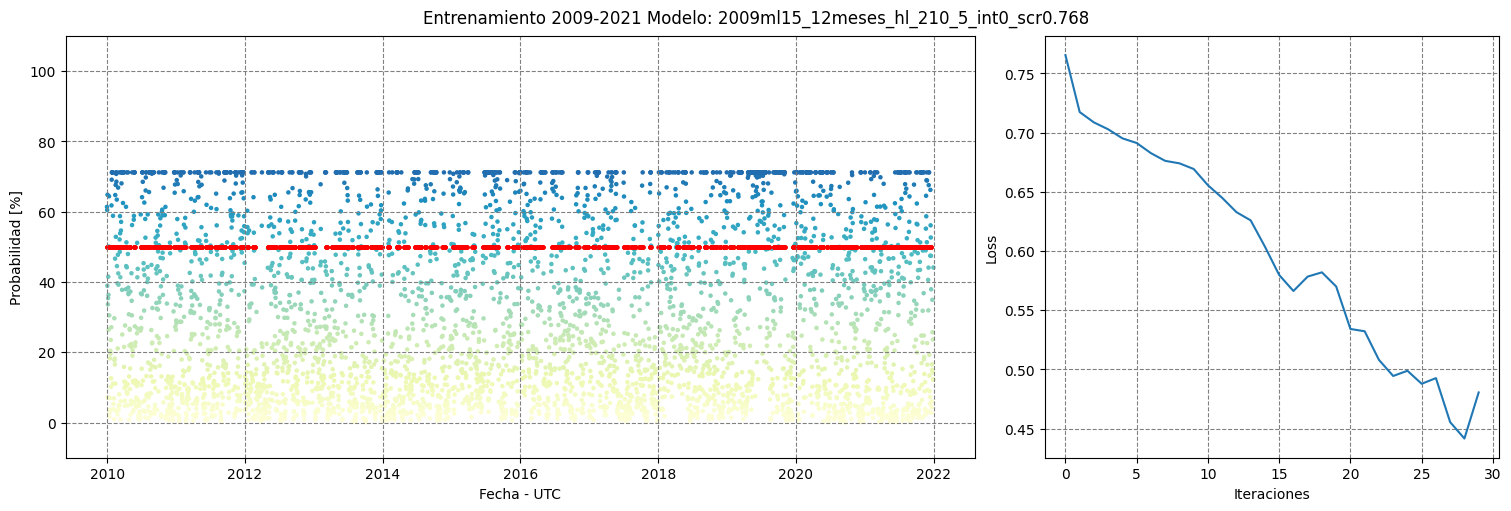

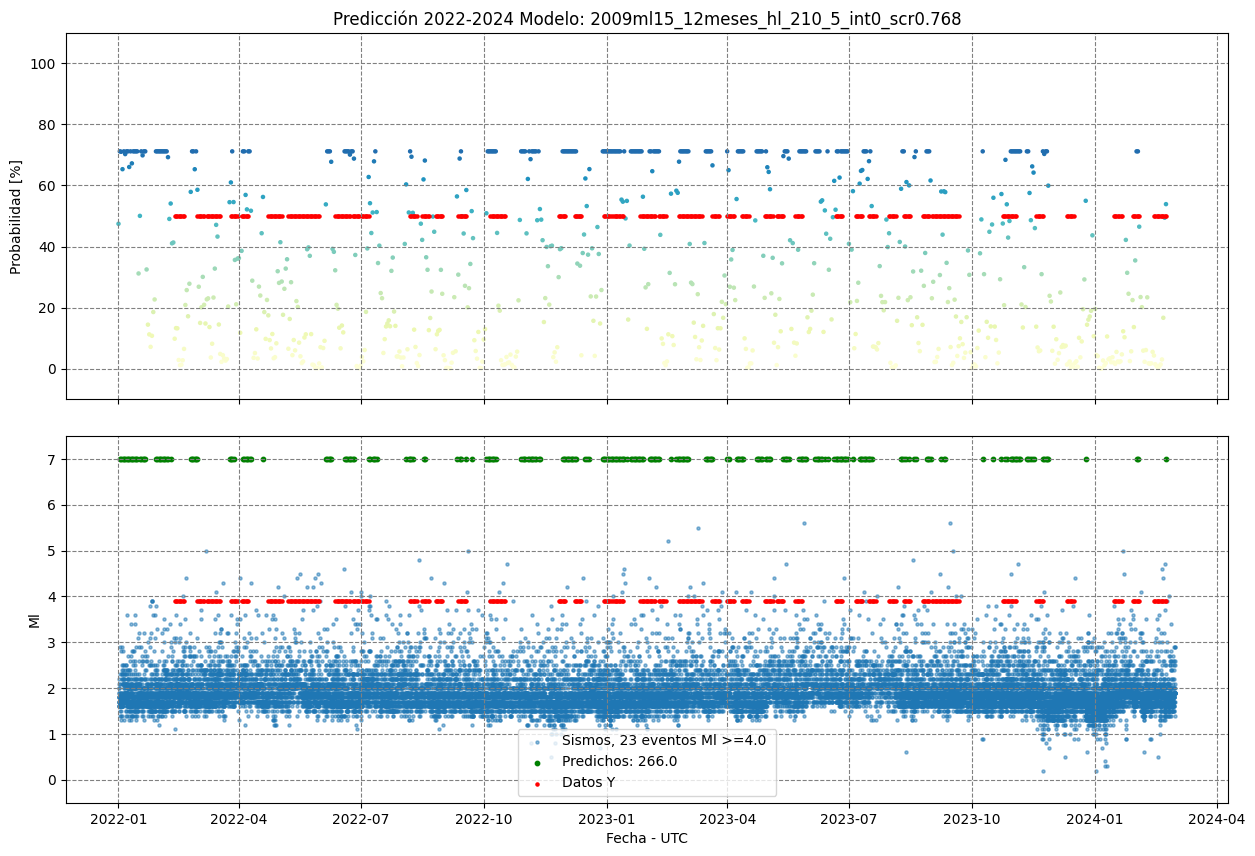

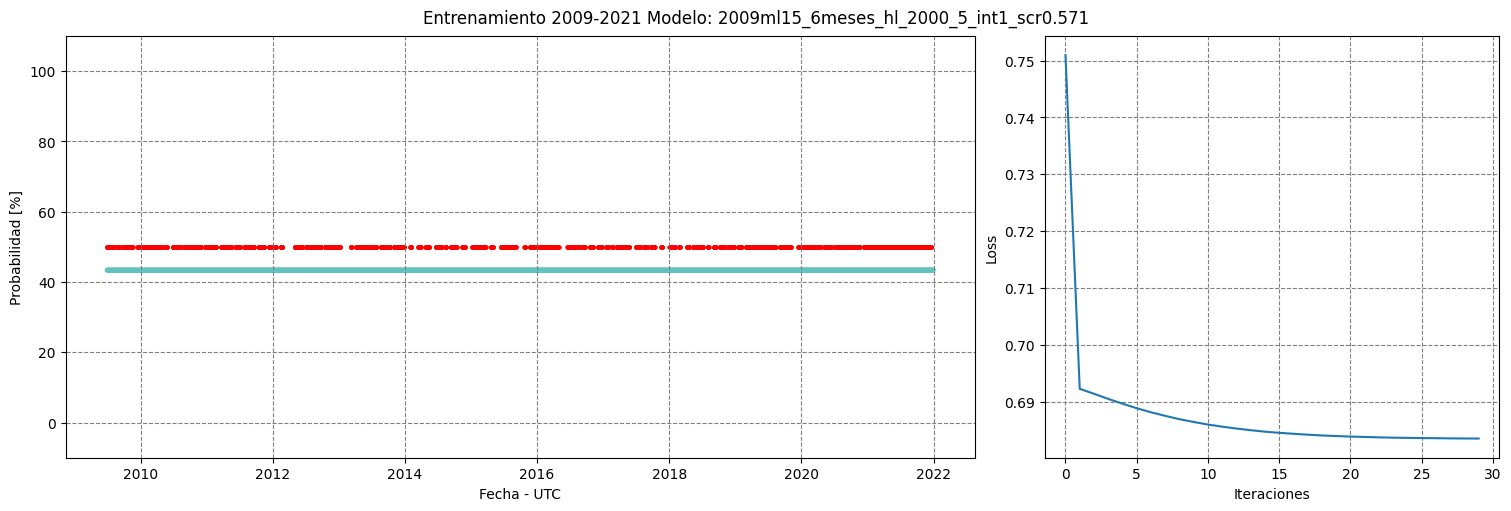

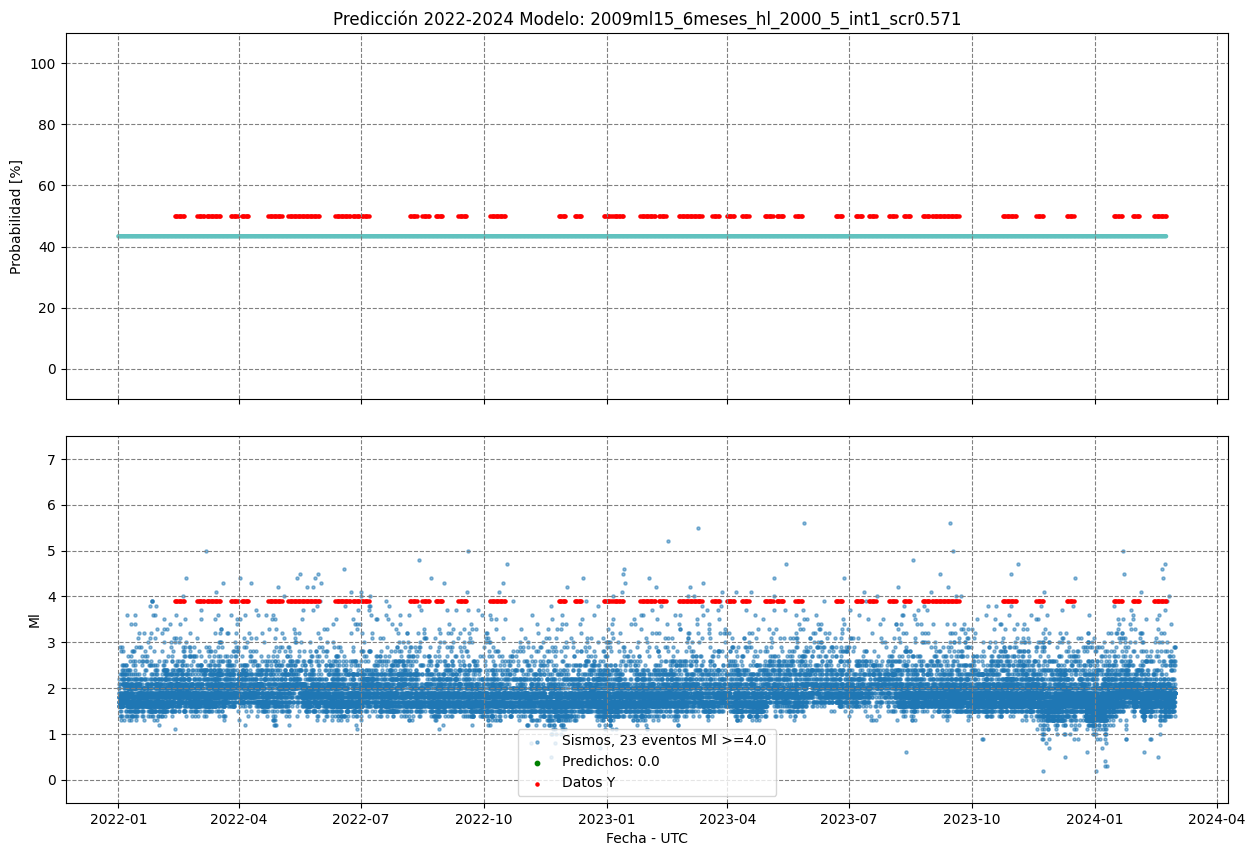

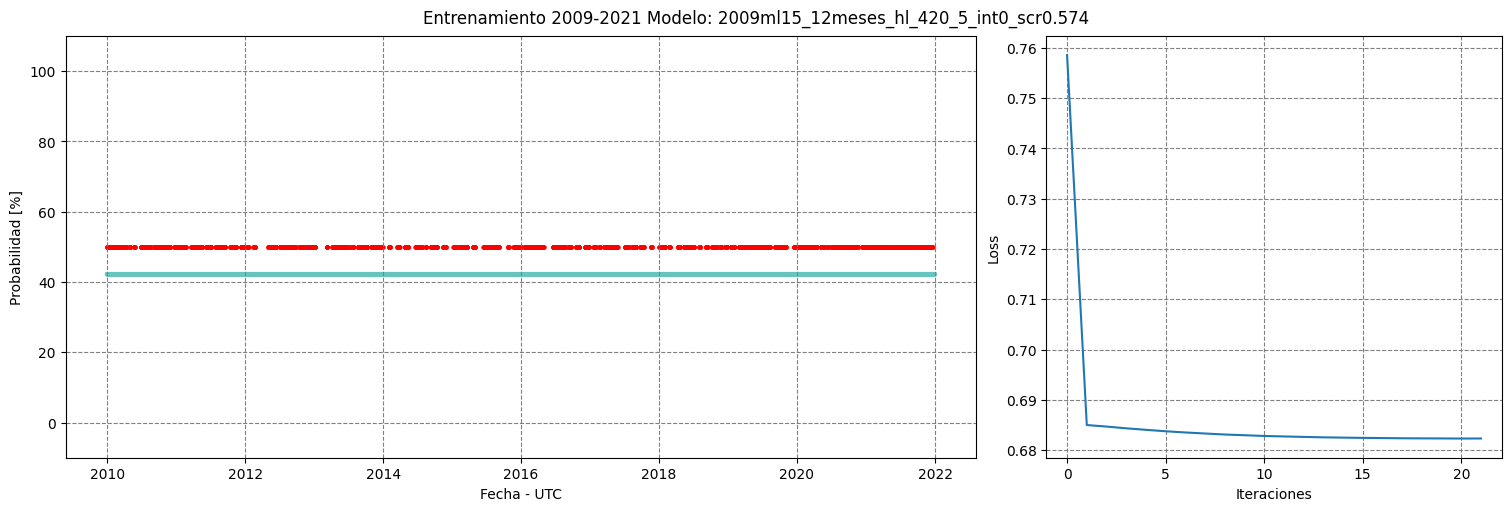

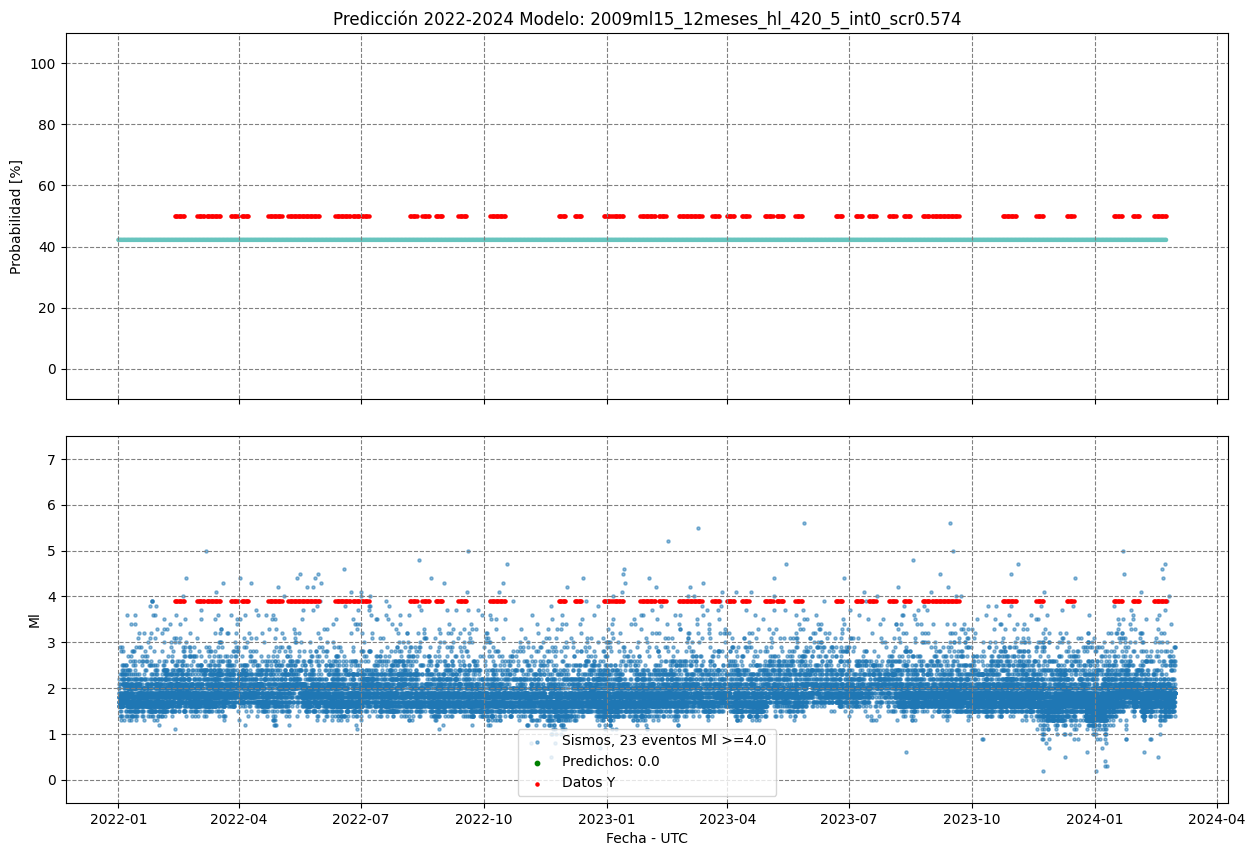

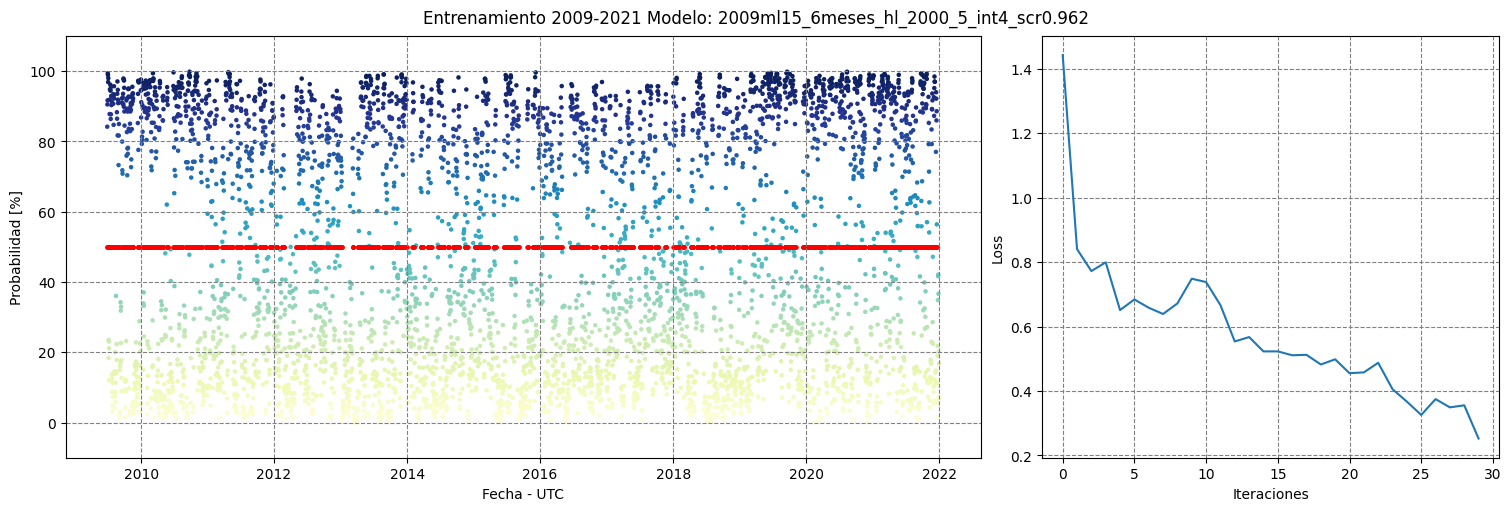

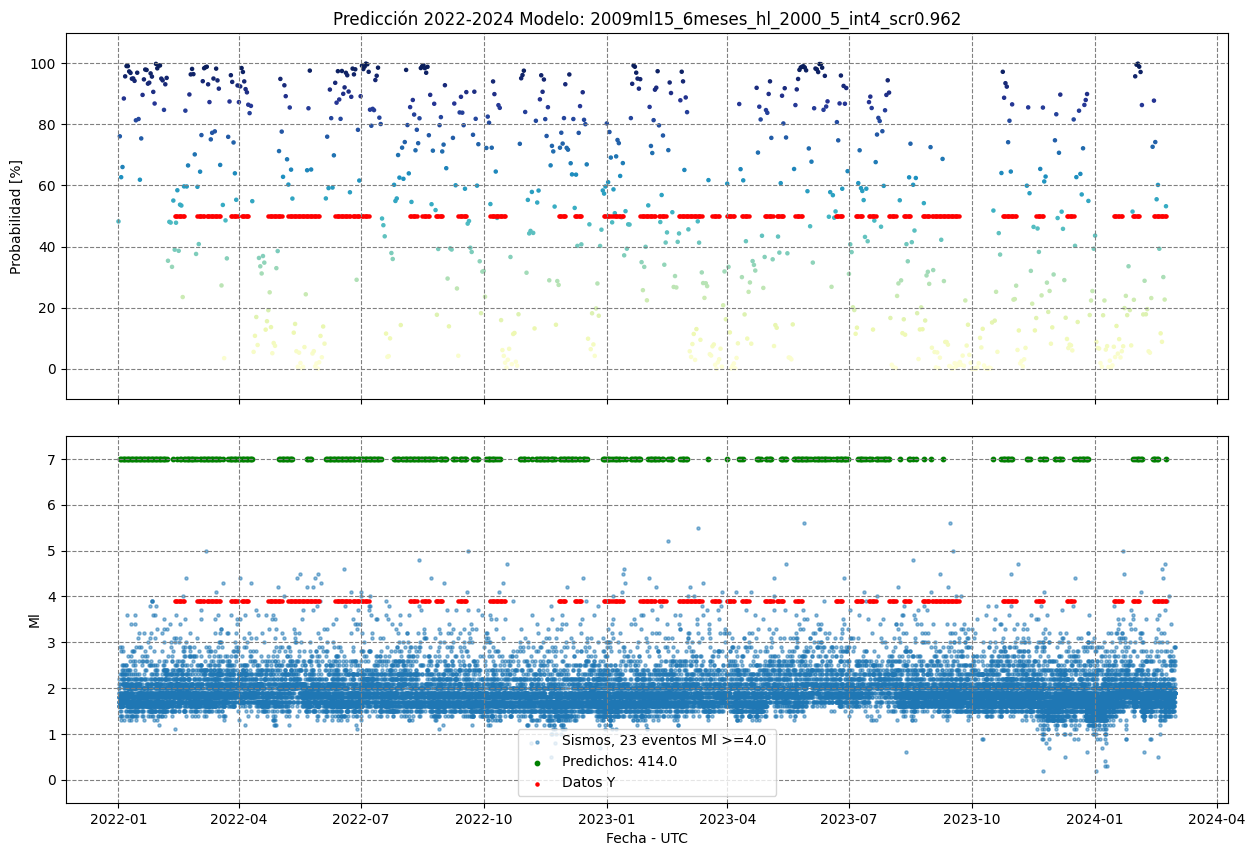

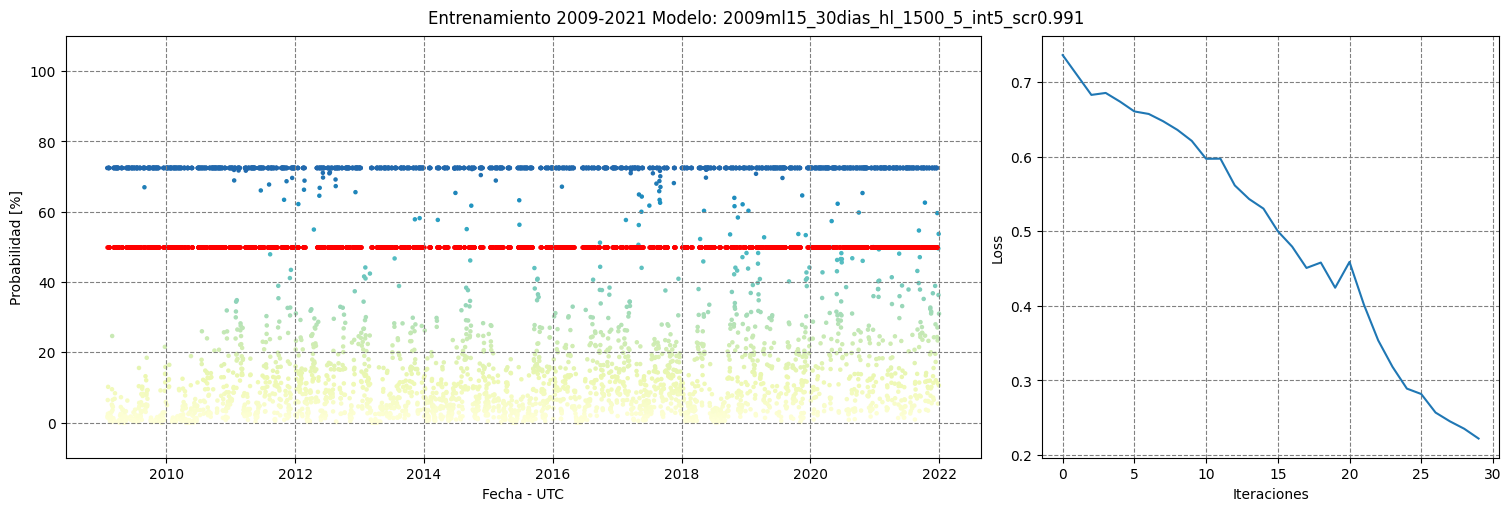

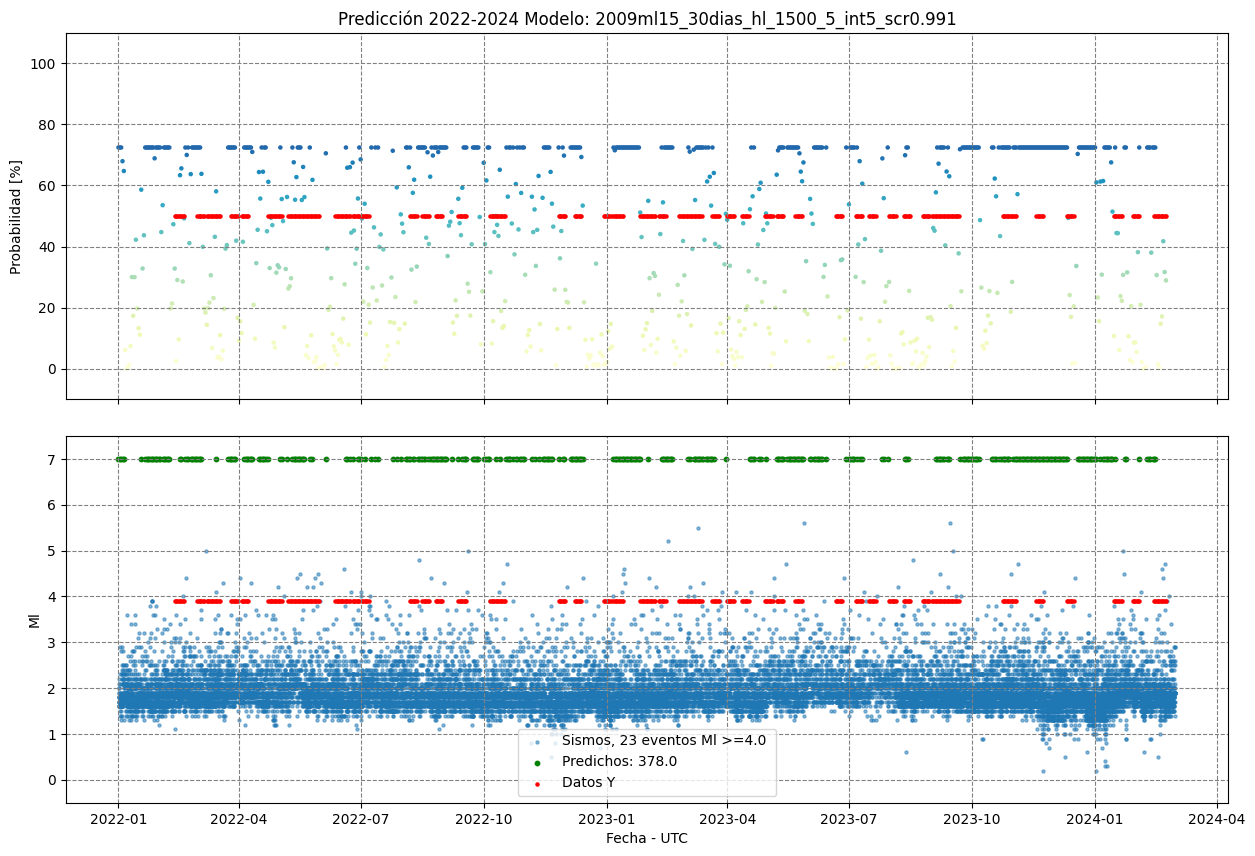

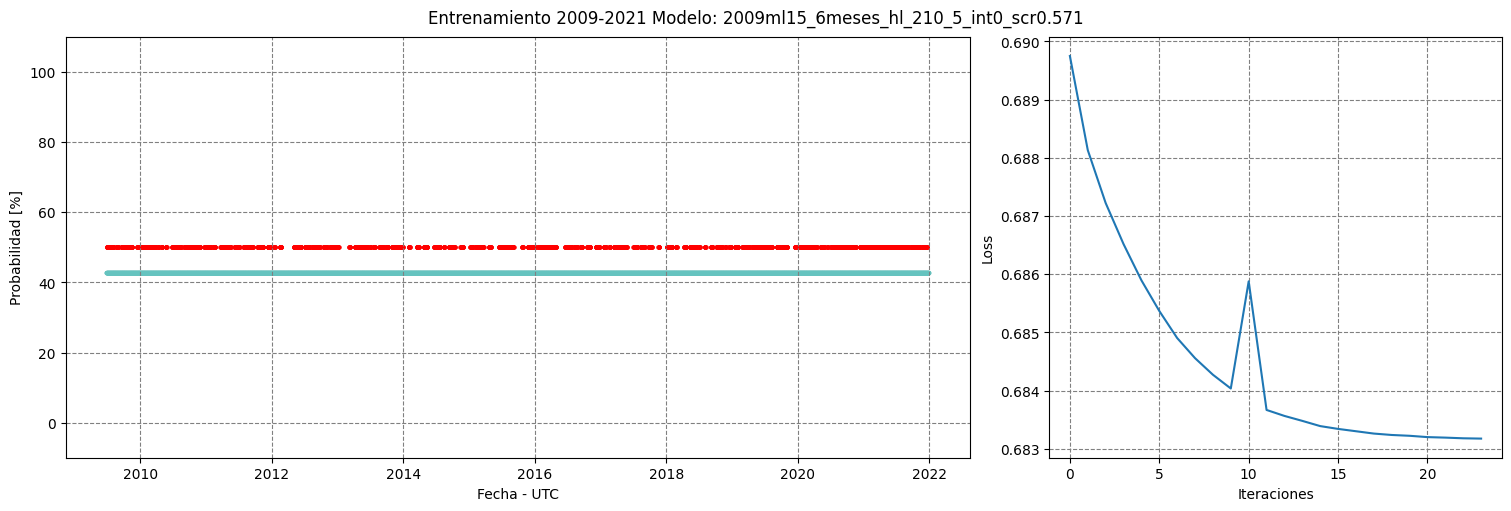

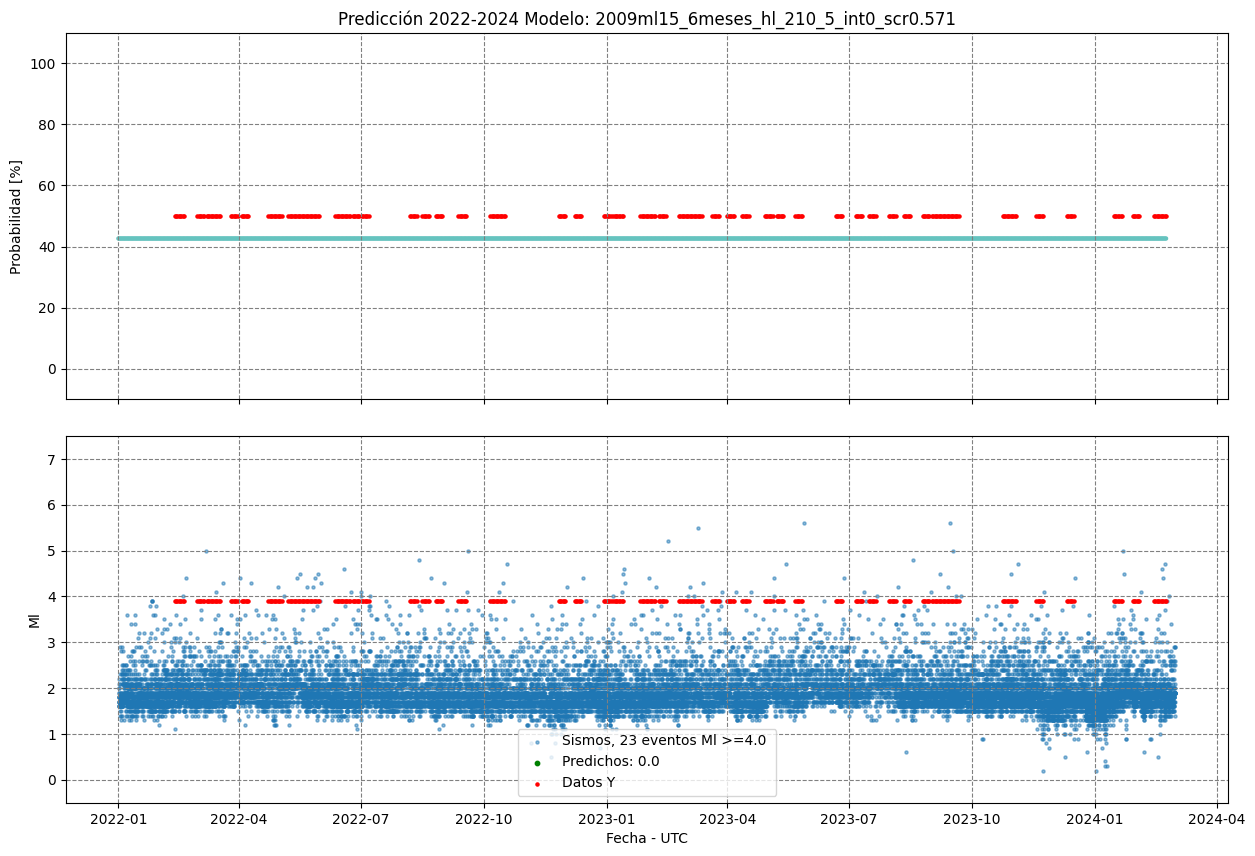

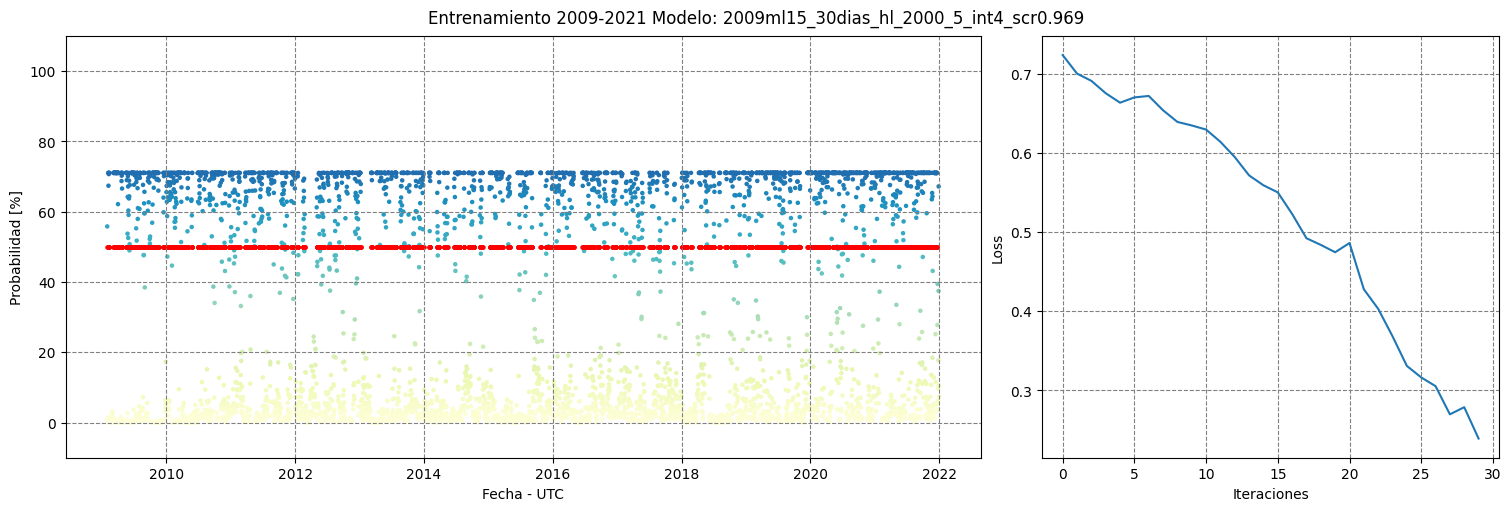

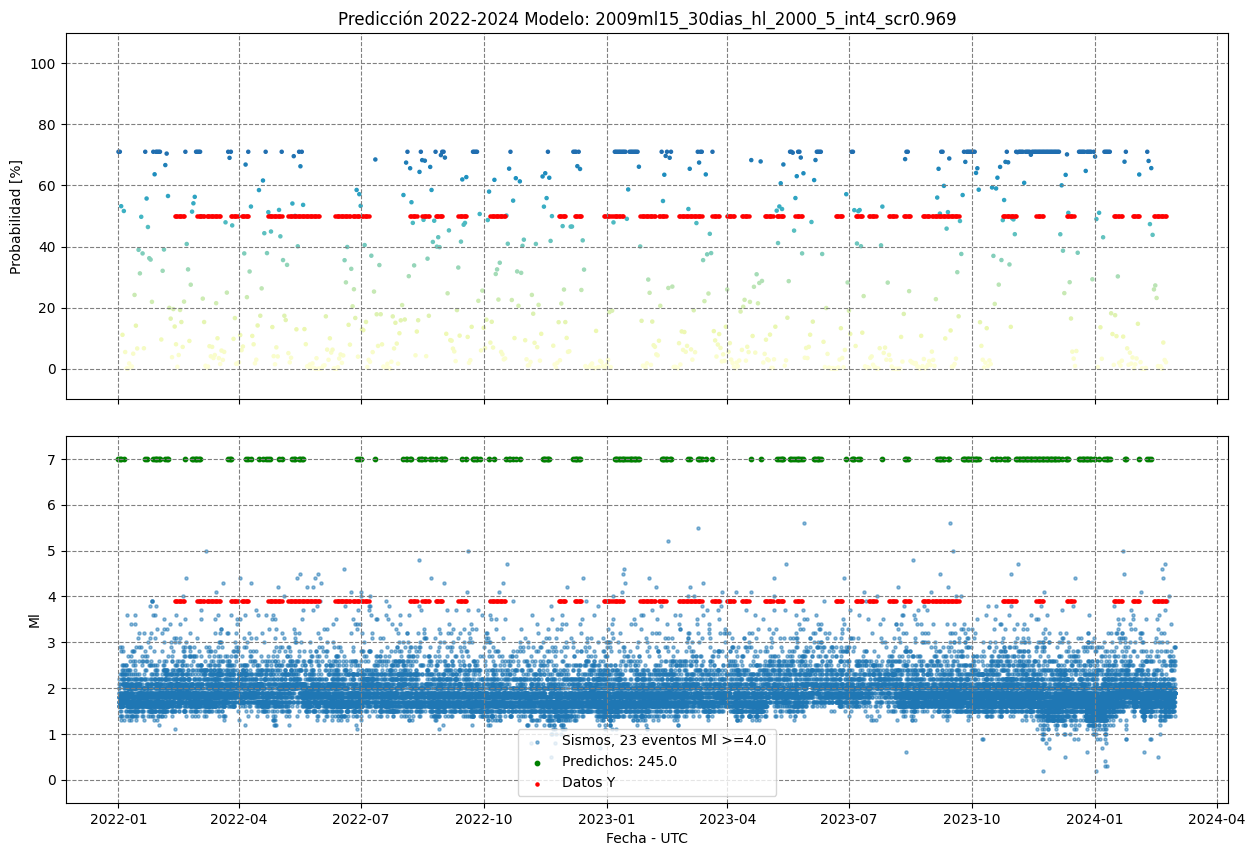

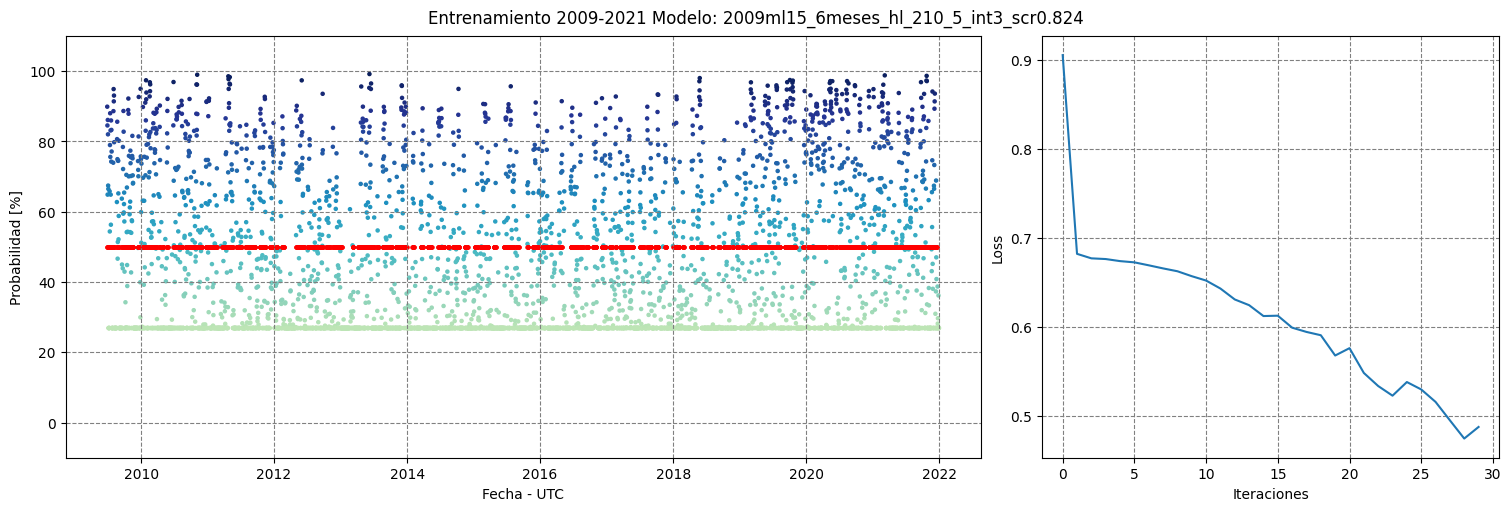

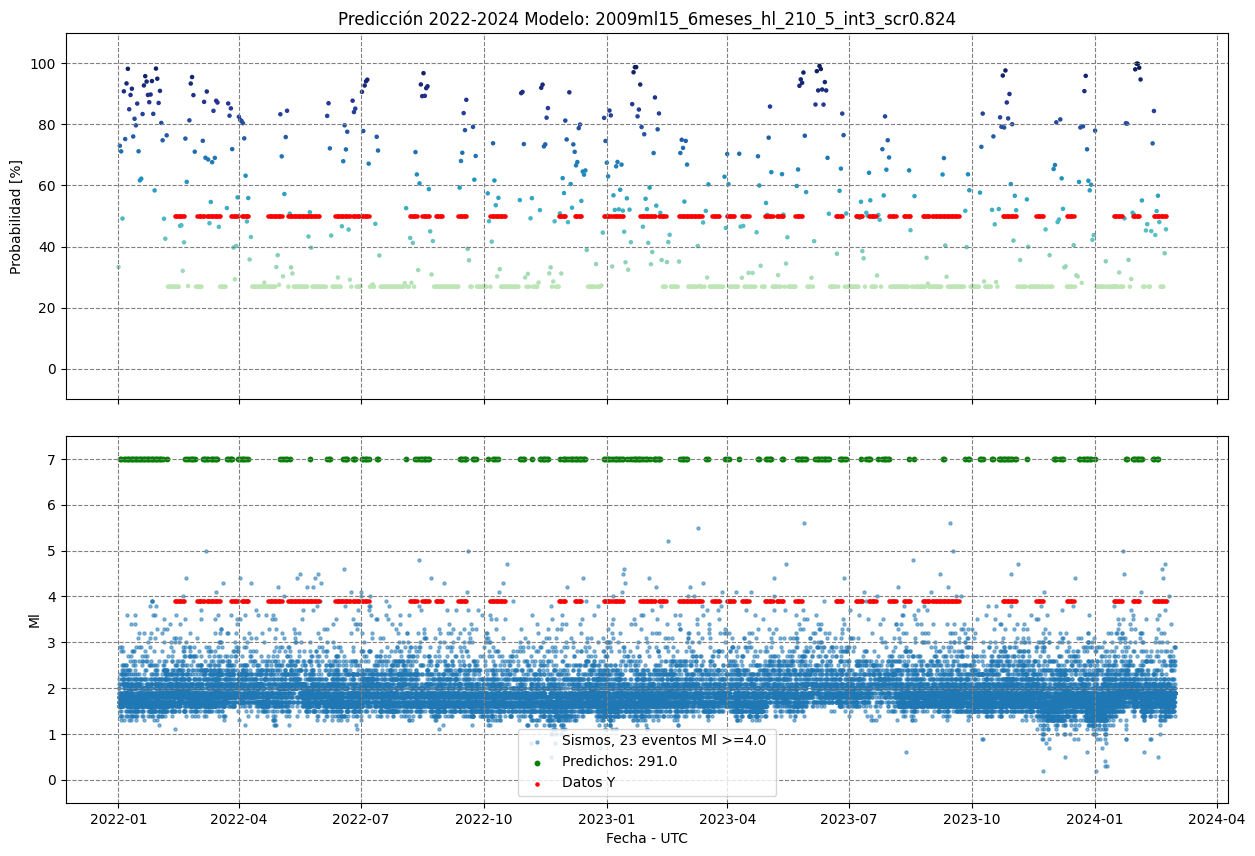

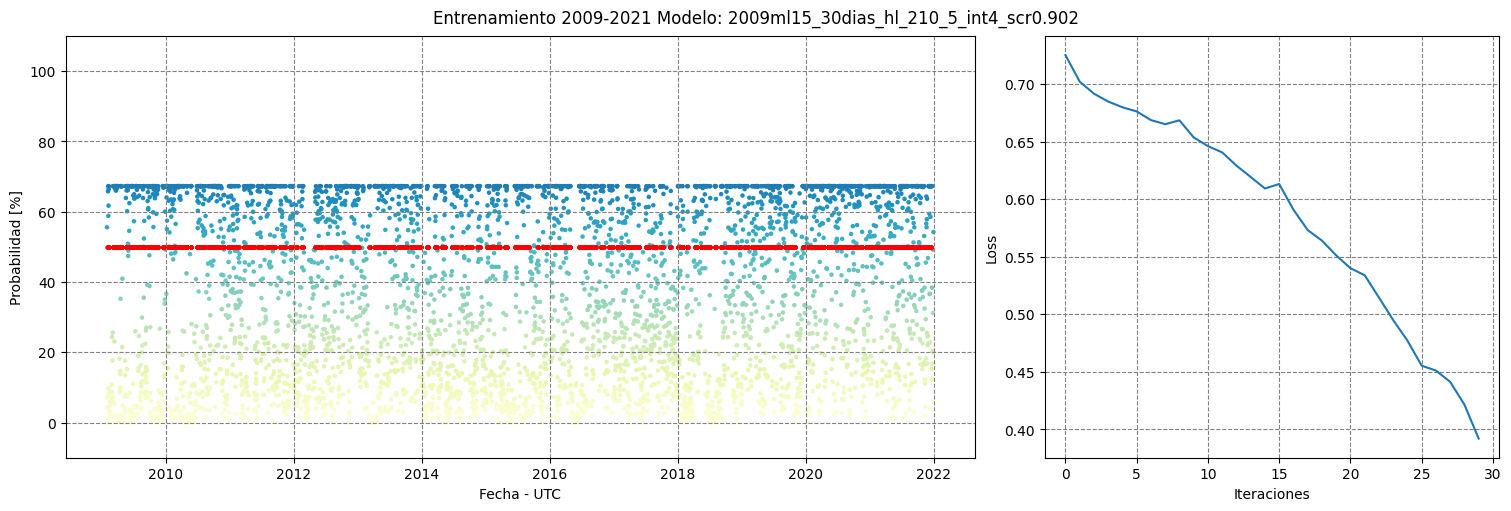

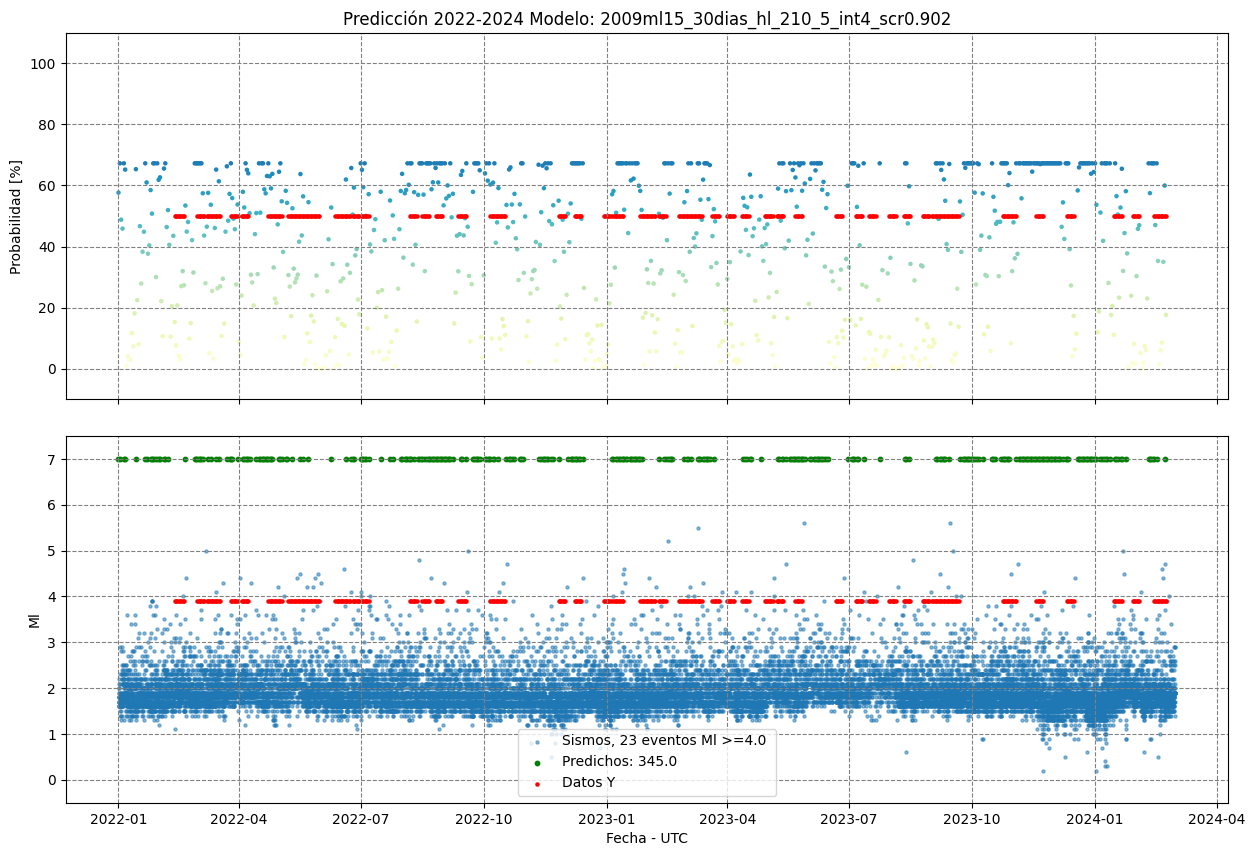

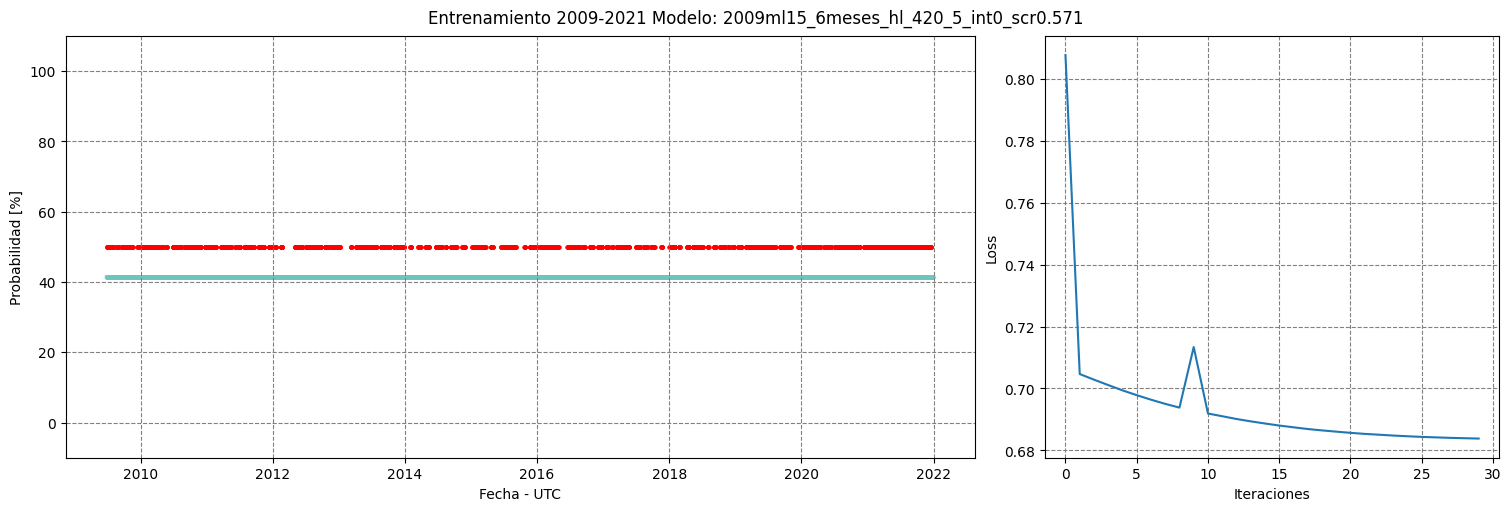

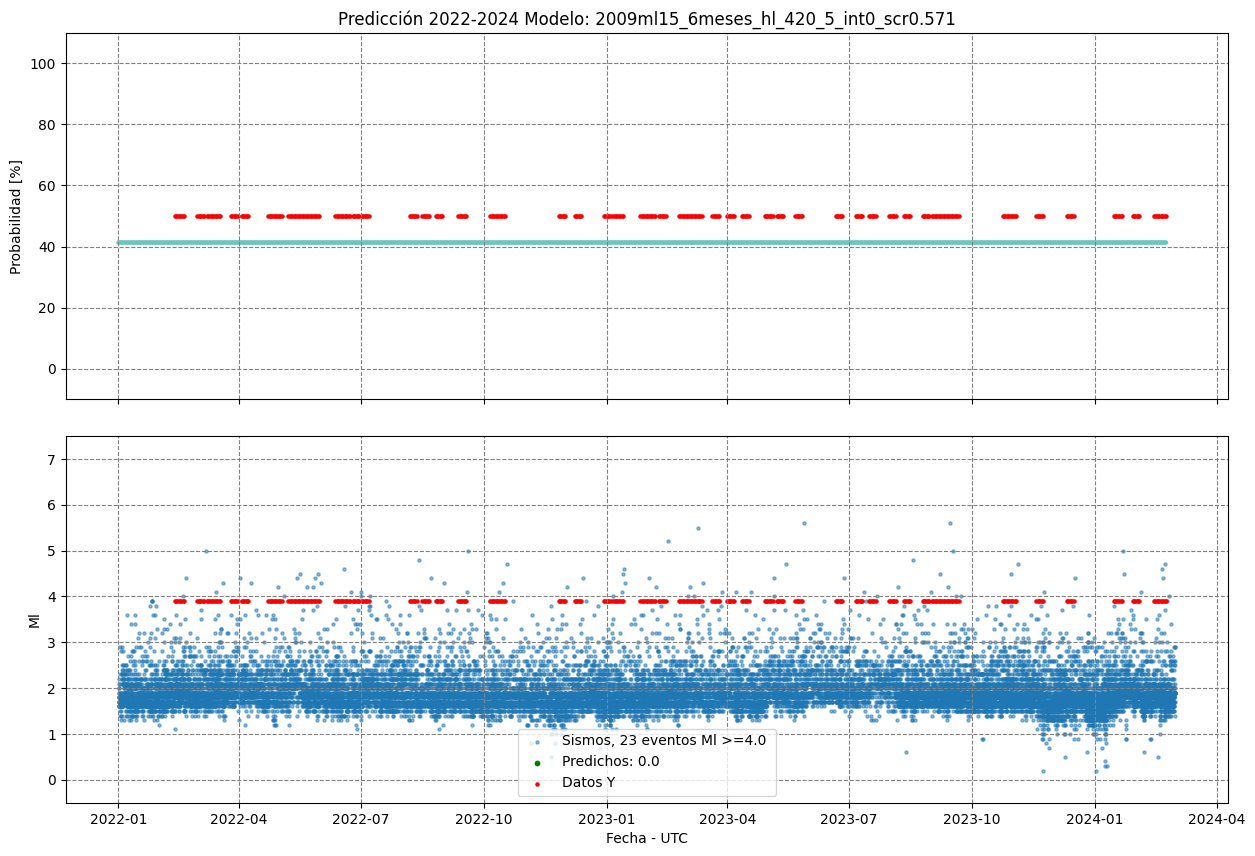

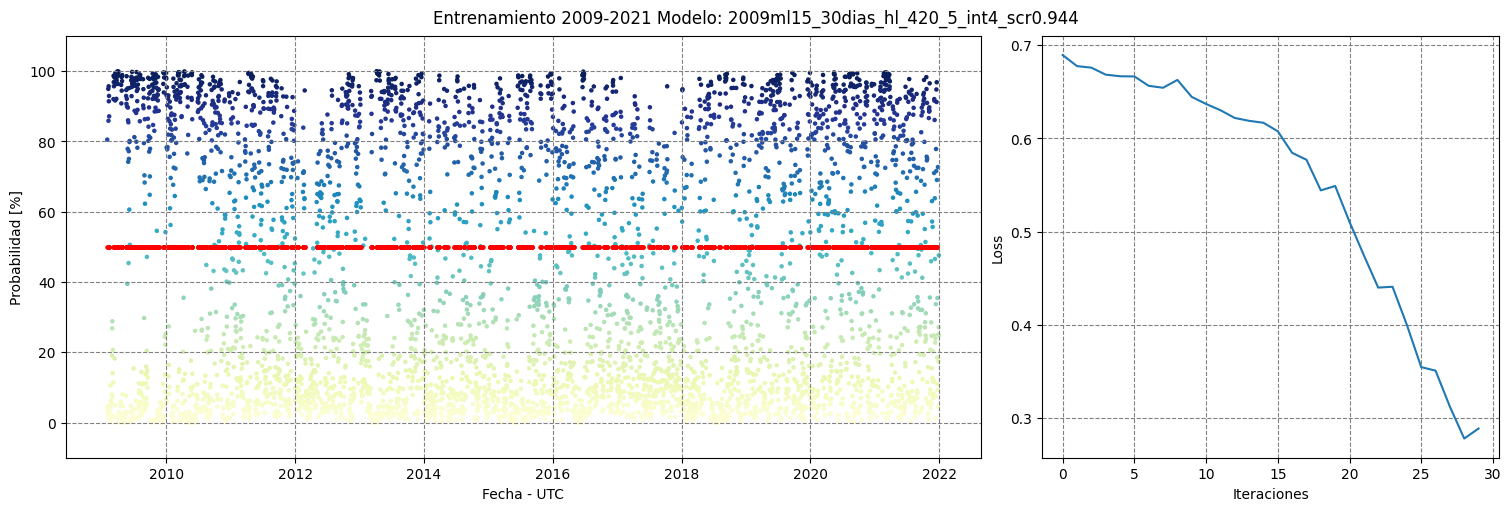

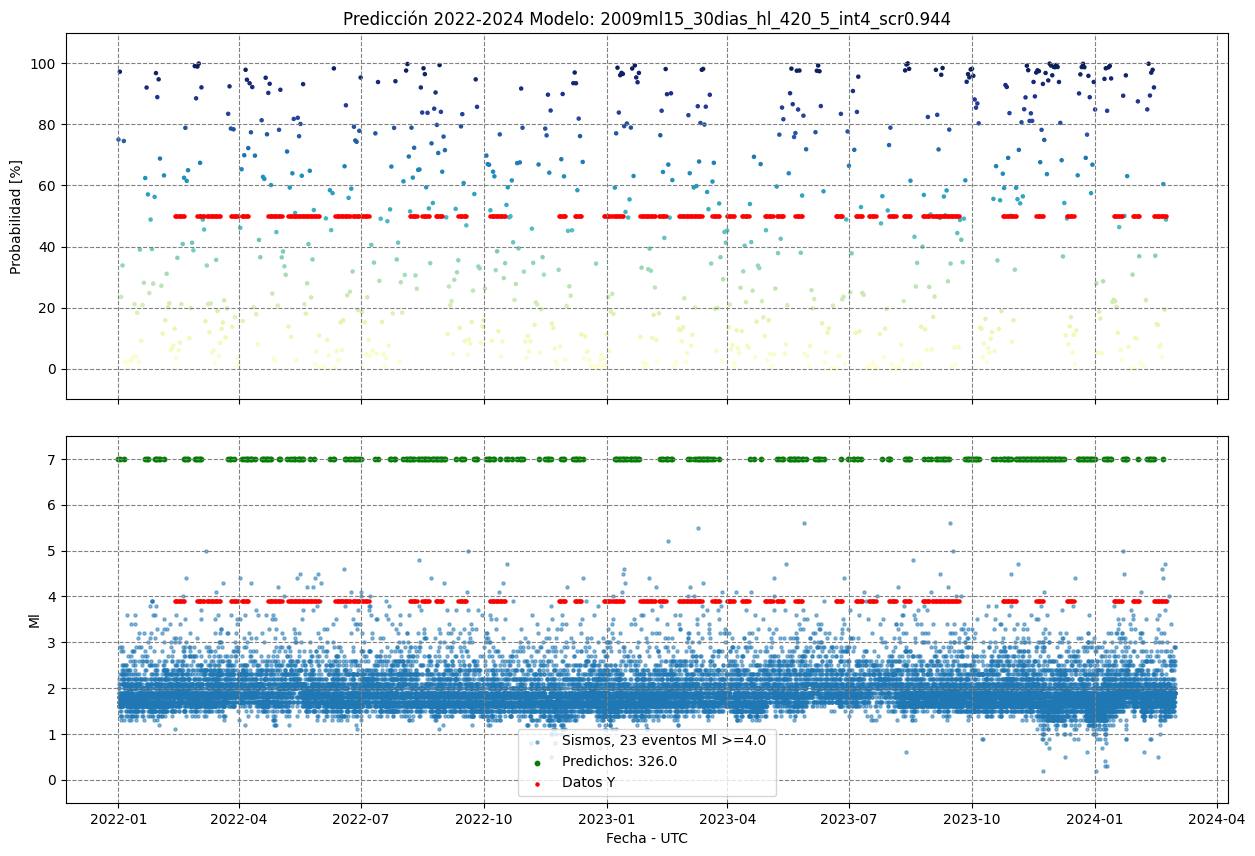

In [ ]:
pathModelos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v5/'

for modelo in listaModelos:
  if 'joblib' in modelo:
    if '6meses' in modelo:
      dias_Considerar = 180
      X2023 = np.loadtxt(pathDatos+'2009ml15_6meses_X2022.txt')
      y2023 = np.loadtxt(pathDatos+'2009ml15_6meses_y2022.txt')
      X2022 = np.loadtxt(pathDatos+'2009ml15_6meses_X2021.txt')
      y2022 = np.loadtxt(pathDatos+'2009ml15_6meses_y2021.txt')

    if '12meses' in modelo:
      dias_Considerar = 365
      X2023 = np.loadtxt(pathDatos+'2009ml15_12meses_X2022.txt')
      y2023 = np.loadtxt(pathDatos+'2009ml15_12meses_y2022.txt')
      X2022 = np.loadtxt(pathDatos+'2009ml15_12meses_X2021.txt')
      y2022 = np.loadtxt(pathDatos+'2009ml15_12meses_y2021.txt')

    if '30dias' in modelo:
      dias_Considerar = 30
      X2023 = np.loadtxt(pathDatos+'2009ml15_30dias_X2022.txt')
      y2023 = np.loadtxt(pathDatos+'2009ml15_30dias_y2022.txt')
      X2022 = np.loadtxt(pathDatos+'2009ml15_30dias_X2021.txt')
      y2022 = np.loadtxt(pathDatos+'2009ml15_30dias_y2021.txt')


    modelo_P = load(pathModelos+modelo)
    # 2023
    predichosModelo = modelo_P.predict(X2023)
    predProb_Modelo = modelo_P.predict_proba(X2023)[:,1]
    # 1994-2023
    #predichosModelo_2022 = modelo_P.predict(X2022)
    predProb_Modelo_2022 = modelo_P.predict_proba(X2022)[:,1]

    nMin = dias_Considerar - 1
    filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
    filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

    # Figura entrenamiento 1994-2021
    fig = plt.figure(figsize=(15,5), constrained_layout=True)
    gs = fig.add_gridspec(1,3)

    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2])

    ax1.scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2022],
                predProb_Modelo_2022*100,
                s= 5,
                c=predProb_Modelo_2022*100,
                cmap='YlGnBu',
                vmin=0,
                vmax=100)

    ax1.scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2022][y2022 >= 1],
                y2022[y2022 >= 1] * 50,
                s= 5,
                c='r')
    ax1.set_ylim(-10, 110)
    ax1.set_ylabel('Probabilidad [%]')
    ax1.set_xlabel('Fecha - UTC')
    ax1.grid(ls='--', color='grey')

    ax2.plot(np.arange(len(modelo_P.loss_curve_)),
            modelo_P.loss_curve_)
    ax2.grid(ls='--', color='grey')
    ax2.set_xlabel('Iteraciones')
    ax2.set_ylabel('Loss')

    plt.suptitle(f'Entrenamiento 2009-2021 Modelo: {modelo[:-7]}')

    plt.savefig((pathSaveFiguras + f'2009_2021_{modelo[:-7]}.png'),
                format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()
    print('\n')


    # Figuras 2023
    fig, ax = plt.subplots(2,1, figsize=(15,10), sharex=True)
    fig.subplots_adjust(hspace=0.1)

    # Probabilidad
    ax[0].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023],
                predProb_Modelo*100,
                s= 5,
                c=predProb_Modelo*100,
                cmap='YlGnBu',
                vmin=0,
                vmax=100)

    ax[0].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023][y2023 >= 1],
                y2023[y2023 >= 1] * 50,
                s= 5,
                c='r')

    ax[0].set_ylim(-10, 110)
    ax[0].set_ylabel('Probabilidad [%]')
    #ax[0].set_xlabel('Fecha - UTC')
    ax[0].grid(ls='--', color='grey')
    ax[0].set_title(f'Predicción 2022-2024 Modelo: {modelo[:-7]}')

    # Eventos logrados
    event4_5 = df['MAGNITUD Ml'][(df['Date-Time'].dt.year >= 2022).to_numpy()]
    event4_5 = event4_5 >= 4.5
    event4_5 = sum(event4_5)
    ax[1].scatter(df['Date-Time'][(df['Date-Time'].dt.year >= 2022).to_numpy()],
                df['MAGNITUD Ml'][(df['Date-Time'].dt.year >= 2022).to_numpy()],
                s=5,
                label=f'Sismos, {event4_5} eventos Ml >=4.0 ',
                alpha=0.5)

    ax[1].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023][predichosModelo >= 1],
                predichosModelo[predichosModelo >= 1]*7,
                s= 10,
                c='g',
                label=f'Predichos: {sum(predichosModelo)}')


    ax[1].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023][y2023 >= 1],
                y2023[y2023 >= 1] * 3.9,
                s= 5,
                c='r',
                label='Datos Y')

    ax[1].set_ylim(-0.5, 7.5)
    ax[1].set_ylabel('Ml')
    ax[1].set_xlabel('Fecha - UTC')
    ax[1].grid(ls='--', color='grey')


    plt.legend(loc=8)

    plt.savefig((pathSaveFiguras + f'2022_{modelo[:-7]}.png'),
                format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()

    print('\n')

# Confusion Matrix

## V5

In [ ]:
pathModelos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v5/'
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Figuras_MatrizConfusion/'

listaModelos = ['2009ml15_12meses_hl_1500_5_int0_scr0.574.joblib',
                '2009ml15_6meses_hl_1500_5_int0_scr0.932.joblib',
                '2009ml15_12meses_hl_2000_5_int0_scr0.574.joblib',
                '2009ml15_6meses_hl_1500_5_int5_scr0.935.joblib',
                '2009ml15_12meses_hl_210_5_int0_scr0.768.joblib',
                '2009ml15_6meses_hl_2000_5_int1_scr0.571.joblib',
                '2009ml15_12meses_hl_420_5_int0_scr0.574.joblib',
                '2009ml15_6meses_hl_2000_5_int4_scr0.962.joblib',
                '2009ml15_30dias_hl_1500_5_int5_scr0.991.joblib',
                '2009ml15_6meses_hl_210_5_int0_scr0.571.joblib',
                '2009ml15_30dias_hl_2000_5_int4_scr0.969.joblib',
                '2009ml15_6meses_hl_210_5_int3_scr0.824.joblib',
                '2009ml15_30dias_hl_210_5_int4_scr0.902.joblib',
                '2009ml15_6meses_hl_420_5_int0_scr0.571.joblib',
                '2009ml15_30dias_hl_420_5_int4_scr0.944.joblib']

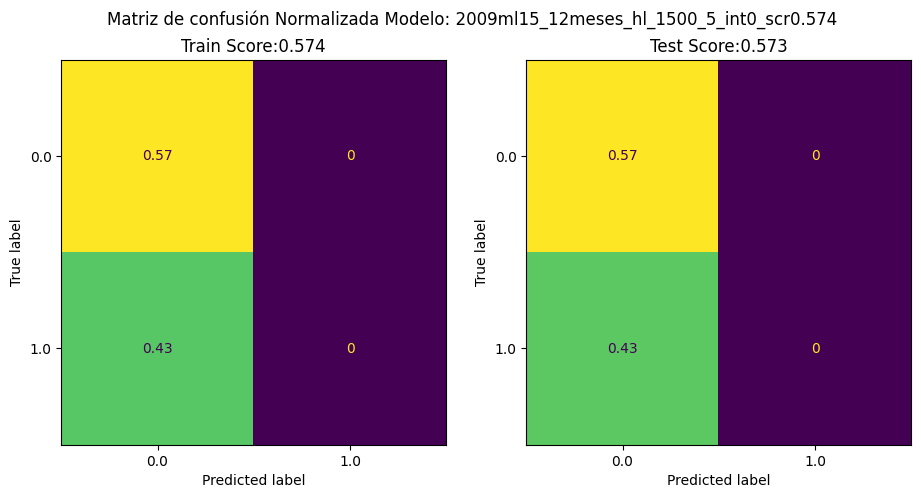

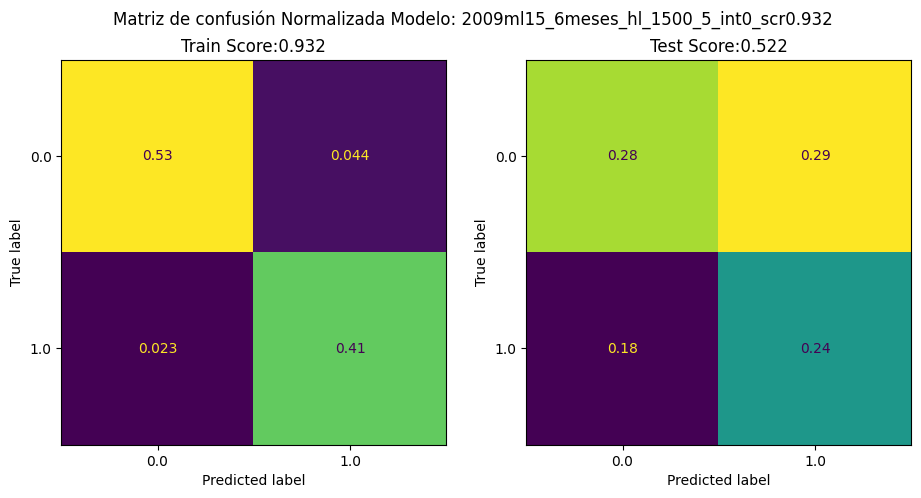

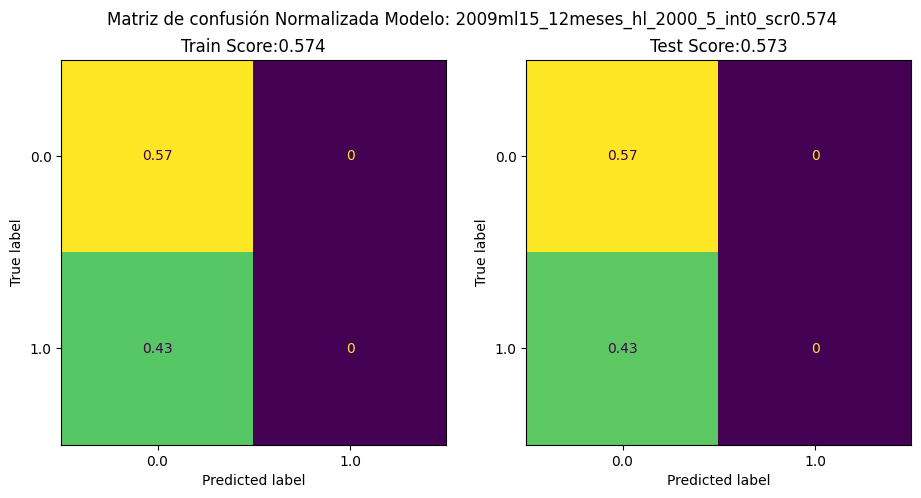

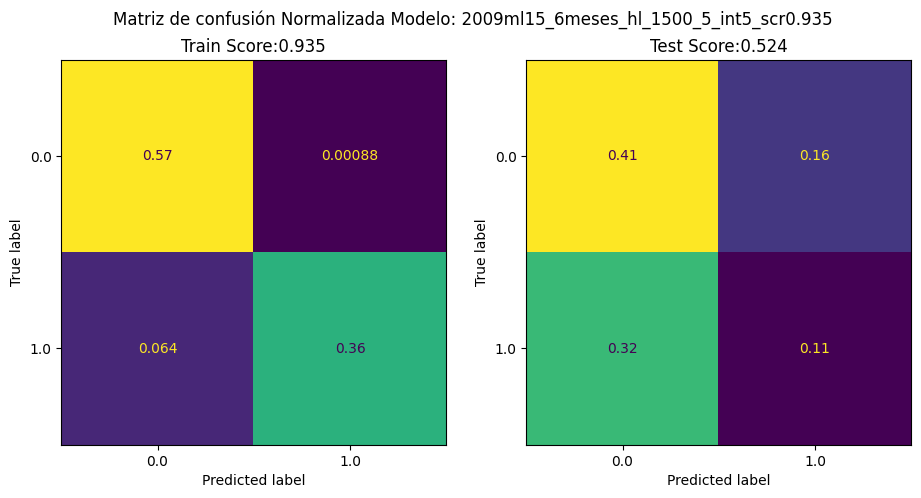

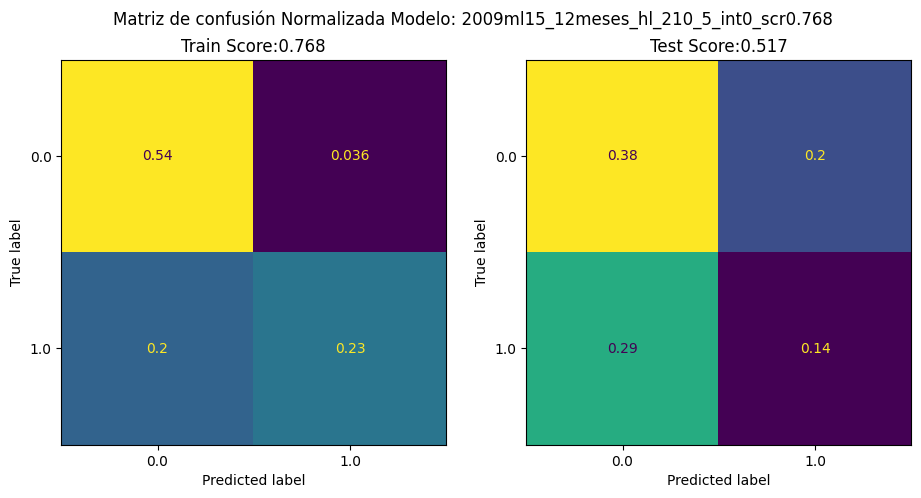

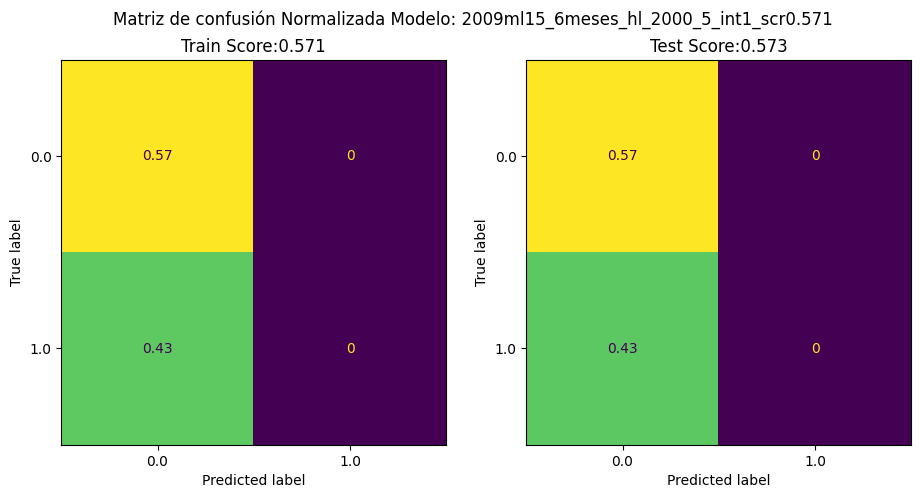

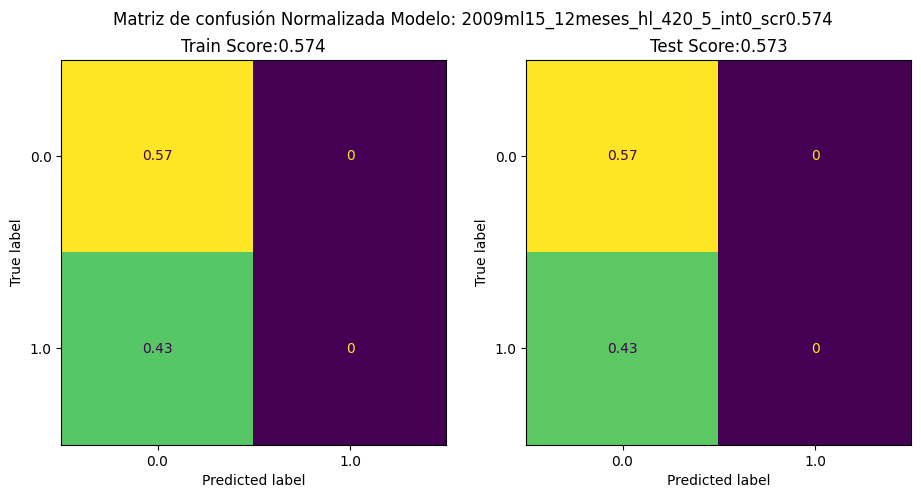

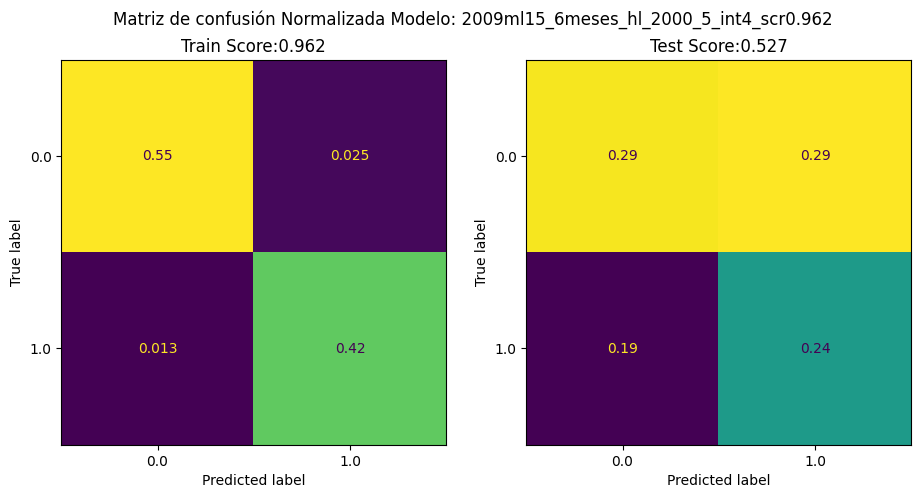

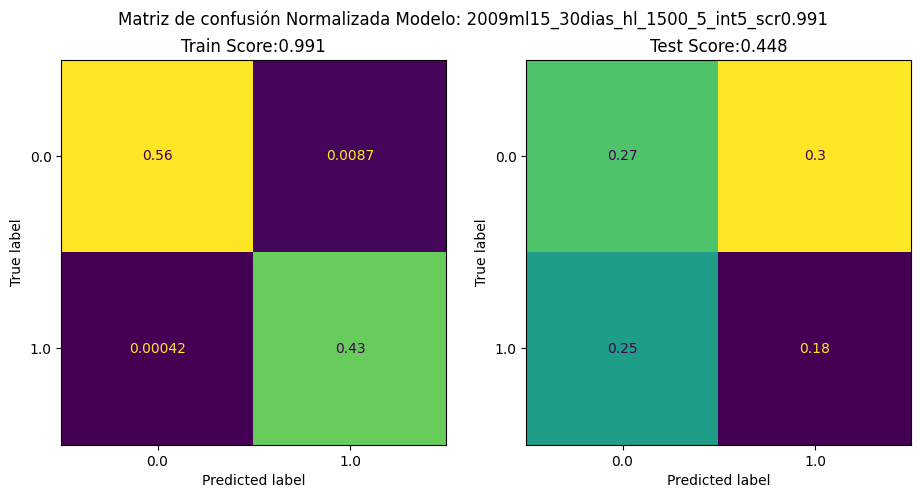

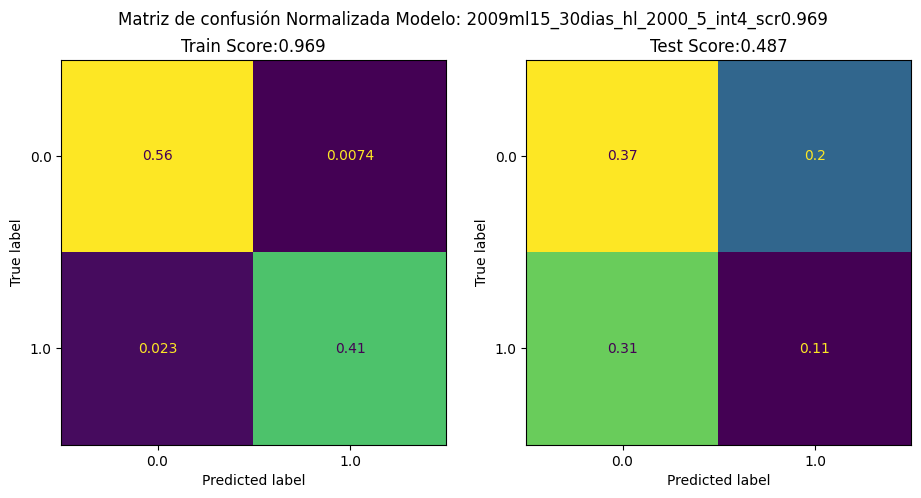

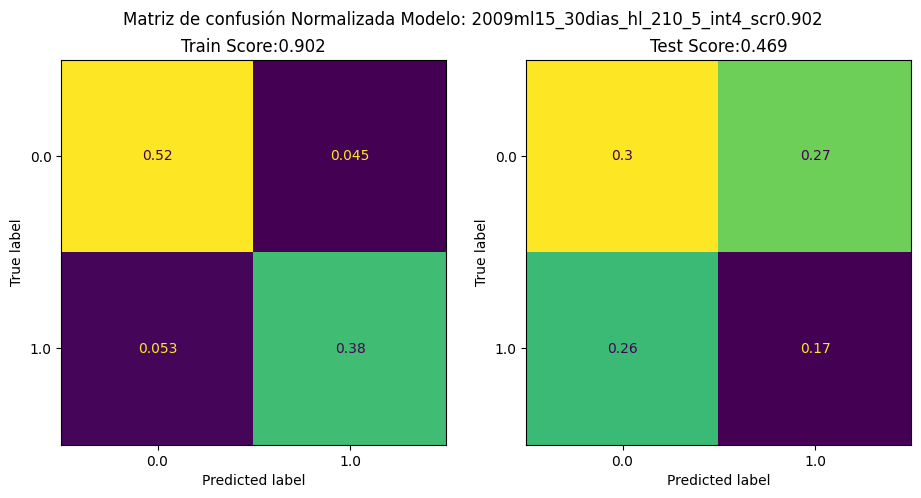

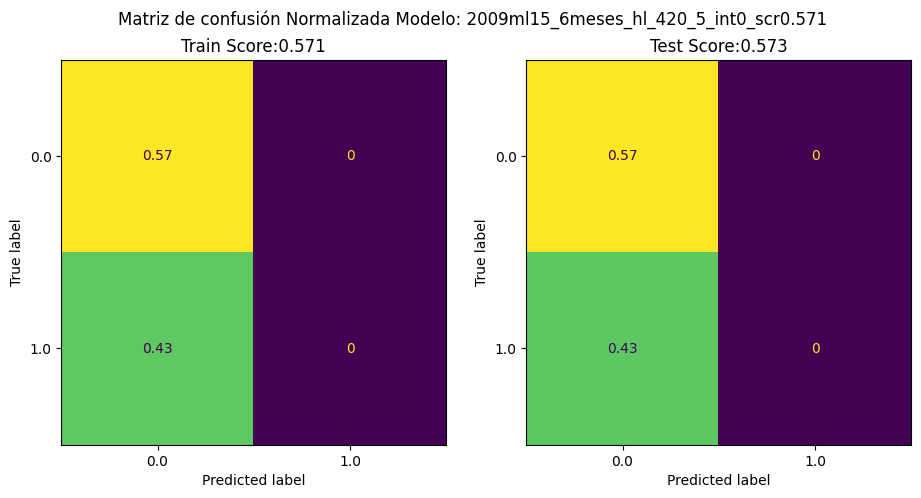

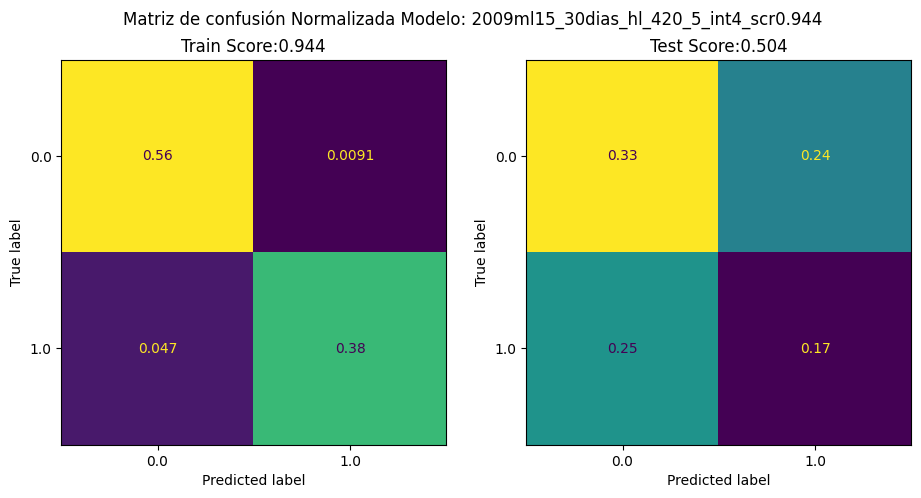

In [ ]:
dictPuntajes = {'Modelo':[],
                'V':[],
                'Train_Score':[],
                'Train_TN':[],
                'Train_FP':[],
                'Train_FN':[],
                'Train_TP':[],
                'Test_Score':[],
                'Test_TN':[],
                'Test_FP':[],
                'Test_FN':[],
                'Test_TP':[]}

for modelo in listaModelos:
  if 'joblib' in modelo:
    if '6meses' in modelo:
      Xtest = np.loadtxt(pathDatos+'2009ml15_6meses_X2022.txt')
      ytest = np.loadtxt(pathDatos+'2009ml15_6meses_y2022.txt')
      Xtrain = np.loadtxt(pathDatos+'2009ml15_6meses_X2021.txt')
      ytrain = np.loadtxt(pathDatos+'2009ml15_6meses_y2021.txt')

    if '12meses' in modelo:
      Xtest = np.loadtxt(pathDatos+'2009ml15_12meses_X2022.txt')
      ytest = np.loadtxt(pathDatos+'2009ml15_12meses_y2022.txt')
      Xtrain = np.loadtxt(pathDatos+'2009ml15_12meses_X2021.txt')
      ytrain = np.loadtxt(pathDatos+'2009ml15_12meses_y2021.txt')

    if '30dias' in modelo:
      Xtest = np.loadtxt(pathDatos+'2009ml15_30dias_X2022.txt')
      ytest = np.loadtxt(pathDatos+'2009ml15_30dias_y2022.txt')
      Xtrain = np.loadtxt(pathDatos+'2009ml15_30dias_X2021.txt')
      ytrain = np.loadtxt(pathDatos+'2009ml15_30dias_y2021.txt')

    modelo_P = load(pathModelos+modelo)
    # Train
    predichosModelo_Train = modelo_P.predict(Xtrain)
    scoreTrain = np.round(modelo_P.score(Xtrain, ytrain), 3)
    tn_Train, fp_Train, fn_Train, tp_Train = confusion_matrix(ytrain, predichosModelo_Train, normalize='all').ravel()

    # Test
    predichosModelo_Test = modelo_P.predict(Xtest)
    accuracyScore_Test = np.round(accuracy_score(ytest, predichosModelo_Test),3)
    tn_Test, fp_Test, fn_Test, tp_Test = confusion_matrix(ytest, predichosModelo_Test, normalize='all').ravel()

    # Incluir en la lista
    dictPuntajes['Modelo'].append(modelo[:-7])
    dictPuntajes['V'].append('v5')
    dictPuntajes['Train_Score'].append(scoreTrain)
    dictPuntajes['Train_TN'].append(tn_Train)
    dictPuntajes['Train_FP'].append(fp_Train)
    dictPuntajes['Train_FN'].append(fn_Train)
    dictPuntajes['Train_TP'].append(tp_Train)
    dictPuntajes['Test_Score'].append(accuracyScore_Test)
    dictPuntajes['Test_TN'].append(tn_Test)
    dictPuntajes['Test_FP'].append(fp_Test)
    dictPuntajes['Test_FN'].append(fn_Test)
    dictPuntajes['Test_TP'].append(tp_Test)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
    #Train

    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytrain, predichosModelo_Train, normalize='all'),
                           display_labels=modelo_P.classes_,
                           ).plot(ax=axs[0], colorbar=False)
    axs[0].set_title(f'Train Score:{scoreTrain}')

    #Test
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytest, predichosModelo_Test, normalize='all'),
                        display_labels=modelo_P.classes_,
                        ).plot(ax=axs[1], colorbar=False)
    axs[1].set_title(f'Test Score:{accuracyScore_Test}')

    plt.suptitle(f'Matriz de confusión Normalizada Modelo: {modelo[:-7]}')

    plt.savefig((pathSaveFiguras + f'v5_{modelo[:-7]}.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()
    print('\n')


df_V5 = pd.DataFrame.from_dict(dictPuntajes)
#df

In [ ]:
df_V5.to_csv(pathDatos+'df_ConfMatrix_V5.csv', index=False)
df_V5 = pd.read_csv(pathDatos+'df_ConfMatrix_V5.csv')
df_V5

Modelo   V  Train_Score  Train_TN  \
0   2009ml15_12meses_hl_1500_5_int0_scr0.574  v5        0.574  0.574133   
1    2009ml15_6meses_hl_1500_5_int0_scr0.932  v5        0.932  0.526373   
2   2009ml15_12meses_hl_2000_5_int0_scr0.574  v5        0.574  0.574133   
3    2009ml15_6meses_hl_1500_5_int5_scr0.935  v5        0.935  0.569928   
4    2009ml15_12meses_hl_210_5_int0_scr0.768  v5        0.768  0.537637   
5    2009ml15_6meses_hl_2000_5_int1_scr0.571  v5        0.571  0.570803   
6    2009ml15_12meses_hl_420_5_int0_scr0.574  v5        0.574  0.574133   
7    2009ml15_6meses_hl_2000_5_int4_scr0.962  v5        0.962  0.545634   
8    2009ml15_30dias_hl_1500_5_int5_scr0.991  v5        0.991  0.560712   
9     2009ml15_6meses_hl_210_5_int0_scr0.571  v5        0.571  0.570803   
10   2009ml15_30dias_hl_2000_5_int4_scr0.969  v5        0.969  0.561983   
11    2009ml15_6meses_hl_210_5_int3_scr0.824  v5        0.824  0.548260   
12    2009ml15_30dias_hl_210_5_int4_scr0.902  v5        0.902  0.524264   
13    2009ml15_6meses_hl_420_5_int0_scr0.571  v5        0.571  0.570803   
14    2009ml15_30dias_hl_420_5_int4_scr0.944  v5        0.944  0.560288   

    Train_FP  Train_FN  Train_TP  Test_Score   Test_TN   Test_FP   Test_FN  \
0   0.000000  0.425867  0.000000       0.573  0.572704  0.000000  0.427296   
1   0.044430  0.023419  0.405778       0.522  0.279337  0.293367  0.184949   
2   0.000000  0.425867  0.000000       0.573  0.572704  0.000000  0.427296   
3   0.000875  0.064347  0.364850       0.524  0.413265  0.159439  0.316327   
4   0.036496  0.195255  0.230611       0.517  0.375000  0.197704  0.285714   
5   0.000000  0.429197  0.000000       0.573  0.572704  0.000000  0.427296   
6   0.000000  0.425867  0.000000       0.573  0.572704  0.000000  0.427296   
7   0.025170  0.012913  0.416284       0.527  0.285714  0.286990  0.186224   
8   0.008688  0.000424  0.430176       0.448  0.269133  0.303571  0.248724   
9   0.000000  0.429197  0.000000       0.573  0.572704  0.000000  0.427296   
10  0.007417  0.023098  0.407502       0.487  0.373724  0.198980  0.313776   
11  0.022543  0.153863  0.275334       0.548  0.375000  0.197704  0.253827   
12  0.045137  0.052977  0.377622       0.469  0.301020  0.271684  0.258929   
13  0.000000  0.429197  0.000000       0.573  0.572704  0.000000  0.427296   
14  0.009112  0.047044  0.383556       0.504  0.330357  0.242347  0.253827   

     Test_TP  
0   0.000000  
1   0.242347  
2   0.000000  
3   0.110969  
4   0.141582  
5   0.000000  
6   0.000000  
7   0.241071  
8   0.178571  
9   0.000000  
10  0.113520  
11  0.173469  
12  0.168367  
13  0.000000  
14  0.173469

# End